## Homework #5. Behaviour exploration improvement
#### Author: `Markiian Mandzak`
#### Total time spent on h/w (in minutes): ~360min

# 0. Setup

## 0.1. Imports

In [1]:
import json
import os
import re
import string
from collections import Counter

import altair as alt
import hdbscan
import langcodes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from imblearn.under_sampling import RandomUnderSampler
from langid.langid import LanguageIdentifier, model as lang_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import umap.umap_ as umap
import gender_guesser.detector as gender

alt.data_transformers.disable_max_rows()

/Users/markson/Desktop/UCU/UCU_6K1S_ComputationalSocialSciences/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DataTransformerRegistry.enable('default')

## 0.2. Constants

In [2]:
DIALOGS_MERGED_DATA_PATH = "../data_personal/merged_data/dialogs_data_all.csv"
DIALOGS_META_MERGED_DATA_PATH = "../data_personal/merged_data/dialogs_users_all.csv"
DICTS_DIR = "tone-dict-ukrainian/dicts"
MY_UID = 540076029

## 0.3. Stopwords

In [3]:
# https://github.com/skupriienko/Ukrainian-Stopwords/blob/master/stopwords_ua_set.txt
uk_stopwords = {'–∞', '–∞–±–∏', '–∞–±–∏–¥–µ', '–∞–±–∏–∫–∏–º', '–∞–±–∏–∫–æ–≥–æ', '–∞–±–∏–∫–æ–ª–∏', '–∞–±–∏–∫–æ–º—É', '–∞–±–∏–∫—É–¥–∏', '–∞–±–∏—Ö—Ç–æ', '–∞–±–∏—á–∏–π', '–∞–±–∏—á–∏–π–æ–≥–æ', '–∞–±–∏—á–∏–π–æ–º—É', '–∞–±–∏—á–∏–º', '–∞–±–∏—á–∏—é', '–∞–±–∏—á–∏—è', '–∞–±–∏—á–∏—î', '–∞–±–∏—á–∏—î–º—É', '–∞–±–∏—á–∏—î—é', '–∞–±–∏—á–∏—î—ó', '–∞–±–∏—á–∏—ó', '–∞–±–∏—á–∏—ó–π', '–∞–±–∏—á–∏—ó–º', '–∞–±–∏—á–∏—ó–º–∏', '–∞–±–∏—á–∏—ó—Ö', '–∞–±–∏—á–æ–≥–æ', '–∞–±–∏—á–æ–º—É', '–∞–±–∏—â–æ', '–∞–±–∏—è–∫–∞', '–∞–±–∏—è–∫–µ', '–∞–±–∏—è–∫–∏–π', '–∞–±–∏—è–∫–∏–º', '–∞–±–∏—è–∫–∏–º–∏', '–∞–±–∏—è–∫–∏—Ö', '–∞–±–∏—è–∫–æ–≥–æ', '–∞–±–∏—è–∫–æ–º—É', '–∞–±–∏—è–∫–æ—é', '–∞–±–∏—è–∫–æ—ó', '–∞–±–∏—è–∫—É', '–∞–±–∏—è–∫—ñ', '–∞–±–∏—è–∫—ñ–π', '–∞–±–∏—è–∫—ñ–º', '–∞–±–æ', '–∞–±–æ—â–æ', '–∞–≤–∂–µ–∂', '–∞–≤–æ—Å—å', '–∞–≥–∞', '–∞–¥', '–∞–¥–∂–µ', '–∞–∂', '–∞–∂–µ–Ω—å', '–∞–∑', '–∞–π', '–∞–ª–µ', '–∞–ª–æ', '–∞–º—ñ–Ω—å', '–∞–Ω—Ç', '–∞–Ω—É', '–∞–Ω—ñ', '–∞–Ω—ñ–¥–µ', '–∞–Ω—ñ–∂', '–∞–Ω—ñ–∑–∞—â–æ', '–∞–Ω—ñ–∫–∏–º', '–∞–Ω—ñ–∫–æ–≥–æ', '–∞–Ω—ñ–∫–æ–≥—ñ—Å—ñ–Ω—å–∫–æ', '–∞–Ω—ñ–∫–æ–ª–∏', '–∞–Ω—ñ–∫–æ–º—É', '–∞–Ω—ñ—Å–∫—ñ–ª—å–∫–∏', '–∞–Ω—ñ—Ö—Ç–æ', '–∞–Ω—ñ—á–∏–º', '–∞–Ω—ñ—á–æ–≥–æ', '–∞–Ω—ñ—á–æ–≥—ñ—Å—ñ–Ω—å–∫–æ', '–∞–Ω—ñ—á–æ–º—É', '–∞–Ω—ñ—â–æ', '–∞–Ω—ñ—è–∫–∞', '–∞–Ω—ñ—è–∫–µ', '–∞–Ω—ñ—è–∫–∏–π', '–∞–Ω—ñ—è–∫–∏–º', '–∞–Ω—ñ—è–∫–∏–º–∏', '–∞–Ω—ñ—è–∫–∏—Ö', '–∞–Ω—ñ—è–∫–æ–≥–æ', '–∞–Ω—ñ—è–∫–æ–º—É', '–∞–Ω—ñ—è–∫–æ—é', '–∞–Ω—ñ—è–∫–æ—ó', '–∞–Ω—ñ—è–∫—É', '–∞–Ω—ñ—è–∫—ñ', '–∞–Ω—ñ—è–∫—ñ–π', '–∞–Ω—ñ—è–∫—ñ–º', '–∞–Ω—ñ—è–∫—ñ—Å–µ–Ω—å–∫–∞', '–∞–Ω—ñ—è–∫—ñ—Å–µ–Ω—å–∫–µ', '–∞–Ω—ñ—è–∫—ñ—Å–µ–Ω—å–∫–∏–π', '–∞–Ω—ñ—è–∫—ñ—Å–µ–Ω—å–∫–∏–º', '–∞–Ω—ñ—è–∫—ñ—Å–µ–Ω—å–∫–∏–º–∏', '–∞–Ω—ñ—è–∫—ñ—Å–µ–Ω—å–∫–∏—Ö', '–∞–Ω—ñ—è–∫—ñ—Å–µ–Ω—å–∫–æ–≥–æ', '–∞–Ω—ñ—è–∫—ñ—Å–µ–Ω—å–∫–æ–º—É', '–∞–Ω—ñ—è–∫—ñ—Å–µ–Ω—å–∫–æ—é', '–∞–Ω—ñ—è–∫—ñ—Å–µ–Ω—å–∫–æ—ó', '–∞–Ω—ñ—è–∫—ñ—Å–µ–Ω—å–∫—É', '–∞–Ω—ñ—è–∫—ñ—Å–µ–Ω—å–∫—ñ', '–∞–Ω—ñ—è–∫—ñ—Å–µ–Ω—å–∫—ñ–π', '–∞–Ω—ñ—è–∫—ñ—Å–µ–Ω—å–∫—ñ–º', '–∞–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–∞', '–∞–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–µ', '–∞–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–∏–π', '–∞–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–∏–º', '–∞–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–∏–º–∏', '–∞–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–∏—Ö', '–∞–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–æ–≥–æ', '–∞–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–æ–º—É', '–∞–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–æ—é', '–∞–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–æ—ó', '–∞–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫—É', '–∞–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫—ñ', '–∞–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫—ñ–π', '–∞–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫—ñ–º', '–∞—Ç', '–∞—Ç–æ', '–∞—Ç–æ–∂', '–∞—É', '–∞—Ö', '–∞—á', '–∞—á–µ–π', '–∞—è–∫–∂–µ', '–±', '–±–∞', '–±–∞–≥–∞—Ç–æ', '–±–∞–≥–∞—Ç—å–º–∞', '–±–∞–≥–∞—Ç—å–æ–º', '–±–∞–≥–∞—Ç—å–æ—Ö', '–±–∞–∑', '–±–∞–π', '–±–∞—Ç', '–±–∞—Ö', '–±–∞—Ü', '–±–∞—à', '–±–µ', '–±–µ–∂', '–±–µ–∑', '–±–µ–∑–ø–µ—Ä–µ—Ä–≤–Ω–æ', '–±–µ–ª', '–±–µ—Ä', '–±–∏', '–±–∏—Ä', '–±–∏—á', '–±–ª–∏–∑—å–∫–æ', '–±–ª–∏–∑—å–∫–æ –≤—ñ–¥', '–±–æ', '–±–æ–≤', '–±–æ–¥', '–±–æ–¥–∞–π', '–±–æ–∑', '–±–æ—à', '–±—É–≤', '–±—É–≤–∞—î', '–±—É–¥–µ', '–±—É–¥–µ–º', '–±—É–¥–µ–º–æ', '–±—É–¥–µ—Ç–µ', '–±—É–¥–µ—à', '–±—É–¥—É', '–±—É–¥—É—Ç—å', '–±—É–¥—å', '–±—É–¥—å –ª–∞—Å–∫–∞', '–±—É–¥—å–º–æ', '–±—É–¥—å—Ç–µ', '–±—É–ª–∞', '–±—É–ª–∏', '–±—É–ª–æ', '–±—É—Ç–∏', '–±—É—Ö', '–±—É—Ü', '–±—É—Ü—ñ–º', '–±—É—Ü—ñ–º—Ç–æ', '–±—ñ', '–±—ñ–±', '–±—ñ–ª—å—à', '–±—ñ–ª—å—à–µ', '–±—ñ–ª—è', '–≤', '–≤ –±—ñ–∫', '–≤ –∑–∞–ª–µ–∂–Ω–æ—Å—Ç—ñ –≤—ñ–¥', '–≤ –º—ñ—Ä—É', '–≤ –Ω–∞–ø—Ä—è–º—ñ –¥–æ', '–≤ –ø–æ—Ä—ñ–≤–Ω—è–Ω–Ω—ñ –∑', '–≤ –ø—Ä–æ—Ü–µ—Å—ñ', '–≤ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ñ', '–≤ —Ä–æ–ª—ñ', '–≤ —Å–∏–ª—É', '–≤ —Å—Ç–æ—Ä–æ–Ω—É', '–≤ —Å—É–ø—Ä–æ–≤–æ–¥—ñ', '–≤ —Ö–æ–¥—ñ', "–≤ —ñ–º'—è", '–≤ —ñ–Ω—Ç–µ—Ä–µ—Å–∞—Ö', '–≤–∞–¥', '–≤–∞–∂–ª–∏–≤–∞', '–≤–∞–∂–ª–∏–≤–µ', '–≤–∞–∂–ª–∏–≤–∏–π', '–≤–∞–∂–ª–∏–≤—ñ', '–≤–∞–∫', '–≤–∞–º', '–≤–∞–º–∏', '–≤–∞–Ω', '–≤–∞—Å', '–≤–∞—Ç', '–≤–∞—à', '–≤–∞—à–∞', '–≤–∞—à–µ', '–≤–∞—à–∏–º', '–≤–∞—à–∏–º–∏', '–≤–∞—à–∏—Ö', '–≤–∞—à–æ–≥–æ', '–≤–∞—à–æ–º—É', '–≤–∞—à–æ—é', '–≤–∞—à–æ—ó', '–≤–∞—à—É', '–≤–∞—à—ñ', '–≤–∞—à—ñ–π', '–≤–∞—à—ñ–º', '–≤–≤–µ—Å—å', '–≤–≤—ñ', '–≤–≥–æ—Ä—É', '–≤–¥–∞–ª–∏–Ω—ñ', '–≤–µ–¥', '–≤–µ—Ä—Ö', '–≤–µ—Å—å', '–≤–µ—Ö', '–≤–∂–µ', '–≤–∑–¥–æ–≤–∂', '–≤–∏', '–≤–∏–∑', '–≤–∏—Å', '–≤–∏—Å–æ—á–∏–Ω—ñ', '–≤–∏—â–µ ', '–≤–π–æ', '–≤–ª–∞—Å–Ω–µ', '–≤–ª–∞—Å—Ç–∏–≤–æ', '–≤–º—ñ—Ç–∏', '–≤–Ω–∞—Å–ª—ñ–¥–æ–∫', '–≤–Ω–∏–∑', '–≤–Ω–∏–∑—É', '–≤–æ', '–≤–æ–Ω', '–≤–æ–Ω–∞', '–≤–æ–Ω–∏', '–≤–æ–Ω–æ', '–≤–æ—Å—å–º–∏–π', '–≤–ø–µ—Ä–µ–¥', '–≤–ø–æ–¥–æ–≤–∂', '–≤–ø–æ–ø–µ—Ä–µ–∫', '–≤–ø—Ä–∏—Ç–∏—Å–∫', '–≤–ø—Ä–∏—Ç—É–ª', '–≤–ø—Ä–æ–¥–æ–≤–∂', '–≤–ø—Ä–æ—Å—Ç', '–≤—Å–µ', '–≤—Å–µ—Ä–µ–¥–∏–Ω—ñ', '–≤—Å–µ—é', '–≤—Å–ª—ñ–¥', '–≤—Å—É–ø–µ—Ä–µ—á', '–≤—Å—å–æ–≥–æ', '–≤—Å—å–æ–º—É', '–≤—Å—é', '–≤—Å—é–¥–∏', '–≤—Å—è', '–≤—Å—è–∫', '–≤—Å—è–∫–∞', '–≤—Å—è–∫–µ', '–≤—Å—è–∫–∏–π', '–≤—Å—è–∫–∏–º', '–≤—Å—è–∫–∏–º–∏', '–≤—Å—è–∫–∏—Ö', '–≤—Å—è–∫–æ–≥–æ', '–≤—Å—è–∫–æ–º—É', '–≤—Å—è–∫–æ—é', '–≤—Å—è–∫–æ—ó', '–≤—Å—è–∫—É', '–≤—Å—è–∫—ñ', '–≤—Å—è–∫—ñ–π', '–≤—Å—è–∫—ñ–º', '–≤—Å—ñ', '–≤—Å—ñ–π', '–≤—Å—ñ–ª—è–∫–∞', '–≤—Å—ñ–ª—è–∫–µ', '–≤—Å—ñ–ª—è–∫–∏–π', '–≤—Å—ñ–ª—è–∫–∏–º', '–≤—Å—ñ–ª—è–∫–∏–º–∏', '–≤—Å—ñ–ª—è–∫–∏—Ö', '–≤—Å—ñ–ª—è–∫–æ–≥–æ', '–≤—Å—ñ–ª—è–∫–æ–º—É', '–≤—Å—ñ–ª—è–∫–æ—é', '–≤—Å—ñ–ª—è–∫–æ—ó', '–≤—Å—ñ–ª—è–∫—É', '–≤—Å—ñ–ª—è–∫—ñ', '–≤—Å—ñ–ª—è–∫—ñ–π', '–≤—Å—ñ–ª—è–∫—ñ–º', '–≤—Å—ñ–º', '–≤—Å—ñ–º–∞', '–≤—Å—ñ—Ö', '–≤—Å—ñ—î—é', '–≤—Å—ñ—î—ó', '–≤—Ç—ñ–º', '–≤—ñ', '–≤—ñ–≥', '–≤—ñ–¥', '–≤—ñ–¥ —ñ–º–µ–Ω—ñ', '–≤—ñ–¥–¥–∞–ª—ñ–∫ –≤—ñ–¥', '–≤—ñ–¥–∫–æ–ª–∏', '–≤—ñ–¥–Ω–æ—Å–Ω–æ', '–≤—ñ–¥–ø–æ–≤—ñ–¥–Ω–æ', '–≤—ñ–¥–ø–æ–≤—ñ–¥–Ω–æ –¥–æ', '–≤—ñ–¥—Å–æ—Ç–∫—ñ–≤', '–≤—ñ–¥—Ç–µ–ø–µ—Ä', '–≤—ñ–¥—Ç–æ–¥—ñ', '–≤—ñ–Ω', '–≤—ñ—Å—ñ–º', '–≤—ñ—Å—ñ–º–Ω–∞–¥—Ü—è—Ç–∏–π', '–≤—ñ—Å—ñ–º–Ω–∞–¥—Ü—è—Ç—å', '–≤—ñ—Ç', '–≤—ñ—Ñ', '–≤—ñ—Ö', '–≤—ñ—Ü', '–≤—ñ—â–æ', '–≤—ñ—â–æ—Å—å', '–≥', '–≥–∞', '–≥–∞–≤', '–≥–∞—Ä–∞–∑–¥', '–≥–µ', '–≥–µ–∑', '–≥–µ–º', '–≥–µ–ø', '–≥–µ—Ç', '–≥–µ—Ç—å', '–≥–µ—Ö', '–≥–∏', '–≥–∏–∫', '–≥–∏—Ä', '–≥–∏—á', '–≥–º', '–≥–æ', '–≥–æ–≤–æ—Ä–∏–≤', '–≥–æ–≥', '–≥–æ–ø', '–≥–æ—Ü', '–≥—É', '–≥—É–ø', '–¥', '–¥–∞', '–¥–∞–≤–∞–π', '–¥–∞–≤–∞—Ç–∏', '–¥–∞–≤–Ω–æ', '–¥–∞–ª–µ–∫–æ', '–¥–∞–ª–µ–∫–æ –≤—ñ–¥', '–¥–∞–ª—ñ', '–¥–∞—Ä–æ–º', '–¥–≤–∞', '–¥–≤–∞–¥—Ü—è—Ç–∏–π', '–¥–≤–∞–¥—Ü—è—Ç—å', '–¥–≤–∞–Ω–∞–¥—Ü—è—Ç–∏–π', '–¥–≤–∞–Ω–∞–¥—Ü—è—Ç—å', '–¥–≤–æ—Ö', '–¥–≤—ñ', '–¥–µ', "–¥–µ–≤'—è—Ç–∏–π", "–¥–µ–≤'—è—Ç–Ω–∞–¥—Ü—è—Ç–∏–π", "–¥–µ–≤'—è—Ç–Ω–∞–¥—Ü—è—Ç—å", "–¥–µ–≤'—è—Ç—å", '–¥–µ–¥–∞–ª—ñ', '–¥–µ–∫–∏–º', '–¥–µ–∫–æ–≥–æ', '–¥–µ–∫–æ–ª–∏', '–¥–µ–∫–æ–º—É', '–¥–µ–∫–æ—Ç—Ä–∞', '–¥–µ–∫–æ—Ç—Ä–µ', '–¥–µ–∫–æ—Ç—Ä–∏–π', '–¥–µ–∫–æ—Ç—Ä–∏–º', '–¥–µ–∫–æ—Ç—Ä–∏–º–∏', '–¥–µ–∫–æ—Ç—Ä–∏—Ö', '–¥–µ–∫–æ—Ç—Ä–æ–≥–æ', '–¥–µ–∫–æ—Ç—Ä–æ–º—É', '–¥–µ–∫–æ—Ç—Ä–æ—é', '–¥–µ–∫–æ—Ç—Ä–æ—ó', '–¥–µ–∫–æ—Ç—Ä—É', '–¥–µ–∫–æ—Ç—Ä—ñ', '–¥–µ–∫–æ—Ç—Ä—ñ–π', '–¥–µ–∫–æ—Ç—Ä—ñ–º', '–¥–µ–∫—ñ–ª—å–∫–∞', '–¥–µ–∫—ñ–ª—å–∫–æ–º', '–¥–µ–∫—ñ–ª—å–∫–æ–º–∞', '–¥–µ–∫—ñ–ª—å–∫–æ—Ö', '–¥–µ–∫—ñ–º', '–¥–µ—Å—å', '–¥–µ—Å—è—Ç–∏–π', '–¥–µ—Å—è—Ç—å', '–¥–µ—Ö—Ç–æ', '–¥–µ—á–∏–π', '–¥–µ—á–∏–π–æ–≥–æ', '–¥–µ—á–∏–π–æ–º—É', '–¥–µ—á–∏–º', '–¥–µ—á–∏—é', '–¥–µ—á–∏—è', '–¥–µ—á–∏—î', '–¥–µ—á–∏—î–º—É', '–¥–µ—á–∏—î—é', '–¥–µ—á–∏—î—ó', '–¥–µ—á–∏—ó', '–¥–µ—á–∏—ó–π', '–¥–µ—á–∏—ó–º', '–¥–µ—á–∏—ó–º–∏', '–¥–µ—á–∏—ó—Ö', '–¥–µ—á–æ–≥–æ', '–¥–µ—á–æ–º—É', '–¥–µ—á—ñ–º', '–¥–µ—â–æ', '–¥–µ—è–∫–∞', '–¥–µ—è–∫–µ', '–¥–µ—è–∫–∏–π', '–¥–µ—è–∫–∏–º', '–¥–µ—è–∫–∏–º–∏', '–¥–µ—è–∫–∏—Ö', '–¥–µ—è–∫–æ–≥–æ', '–¥–µ—è–∫–æ–º—É', '–¥–µ—è–∫–æ—é', '–¥–µ—è–∫–æ—ó', '–¥–µ—è–∫—É', '–¥–µ—è–∫—ñ', '–¥–µ—è–∫—ñ–π', '–¥–µ—è–∫—ñ–º', '–¥–µ—ñ–Ω–¥–µ', '–¥–ª—è', '–¥–æ', '–¥–æ–±—Ä–µ', '–¥–æ–≤–≥–æ', '–¥–æ–≤–∫–æ–ª–∞', '–¥–æ–≤–∫—ñ–ª', '–¥–æ–≥', '–¥–æ–∫–∏', '–¥–æ–ø–æ–∫–∏', '–¥–æ–ø—ñ—Ä—É', '–¥–æ—Å–∏—Ç—å', '–¥–æ—Å—ñ', '–¥–æ—Ç–µ–ø–µ—Ä', '–¥–æ—Ç–∏', '–¥—Ä—É–≥–∏–π', '–¥—Ä—É–≥–æ', '–¥—É–∂–µ', '–¥—è–∫—É—é', '–¥—ñ–π—Å–Ω–æ', '–¥—ñ–ª', '–µ', '–µ–≥–µ', '–µ–∂', '–µ–π', '–µ—Ä–≥', '–µ—Å—Ç', '–µ—Ç', '–µ—Ö', '–µ—á', '–∂', '–∂–µ', '–∂–æ–¥–µ–Ω', '–∂–æ–¥–Ω–∞', '–∂–æ–¥–Ω–µ', '–∂–æ–¥–Ω–∏–π', '–∂–æ–¥–Ω–∏–º', '–∂–æ–¥–Ω–∏–º–∏', '–∂–æ–¥–Ω–∏—Ö', '–∂–æ–¥–Ω–æ–≥–æ', '–∂–æ–¥–Ω–æ–º—É', '–∂–æ–¥–Ω–æ—é', '–∂–æ–¥–Ω–æ—ó', '–∂–æ–¥–Ω—É', '–∂–æ–¥–Ω—ñ', '–∂–æ–¥–Ω—ñ–π', '–∂–æ–¥–Ω—ñ–º', '–∂–æ–¥–Ω—ñ—Å—ñ–Ω—å–∫–∞', '–∂–æ–¥–Ω—ñ—Å—ñ–Ω—å–∫–µ', '–∂–æ–¥–Ω—ñ—Å—ñ–Ω—å–∫–∏–π', '–∂–æ–¥–Ω—ñ—Å—ñ–Ω—å–∫–∏–º', '–∂–æ–¥–Ω—ñ—Å—ñ–Ω—å–∫–∏–º–∏', '–∂–æ–¥–Ω—ñ—Å—ñ–Ω—å–∫–∏—Ö', '–∂–æ–¥–Ω—ñ—Å—ñ–Ω—å–∫–æ–≥–æ', '–∂–æ–¥–Ω—ñ—Å—ñ–Ω—å–∫–æ–º—É', '–∂–æ–¥–Ω—ñ—Å—ñ–Ω—å–∫–æ—é', '–∂–æ–¥–Ω—ñ—Å—ñ–Ω—å–∫–æ—ó', '–∂–æ–¥–Ω—ñ—Å—ñ–Ω—å–∫—É', '–∂–æ–¥–Ω—ñ—Å—ñ–Ω—å–∫—ñ', '–∂–æ–¥–Ω—ñ—Å—ñ–Ω—å–∫—ñ–π', '–∂–æ–¥–Ω—ñ—Å—ñ–Ω—å–∫—ñ–º', '–∂—É–∑', '–∑', '–∑ –º–µ—Ç–æ—é', '–∑ –Ω–∞–≥–æ–¥–∏', '–∑ –ø—Ä–∏–≤–æ–¥—É', '–∑ —Ä–æ–∑—Ä–∞—Ö—É–Ω–∫—É –Ω–∞', '–∑-–∑–∞', '–∑-–Ω–∞–¥', '–∑-–ø–µ—Ä–µ–¥', '–∑-–ø–æ–∑–∞', '–∑-–ø–æ–º—ñ–∂', '–∑-–ø–æ–Ω–∞–¥', '–∑-–ø–æ–ø–µ—Ä–µ–¥', '–∑-–ø–æ—Å–µ—Ä–µ–¥', '–∑-–ø—Ä–æ–º—ñ–∂', '–∑-–ø—ñ–¥', '–∑-—Å–µ—Ä–µ–¥', '–∑–∞', '–∑–∞ –≤–∏–Ω—è—Ç–∫–æ–º', '–∑–∞ –¥–æ–ø–æ–º–æ–≥–æ—é', '–∑–∞ –ø–æ—Å–µ—Ä–µ–¥–Ω–∏—Ü—Ç–≤–æ–º', '–∑–∞ —Ä–∞—Ö—É–Ω–æ–∫', '–∑–∞–≤–≥–æ–¥–Ω–æ', '–∑–∞–≤–¥—è–∫–∏', '–∑–∞–≤–∂–¥–∏', '–∑–∞–≤—à–µ', '–∑–∞–¥–ª—è', '–∑–∞–∑–≤–∏—á–∞–π', '–∑–∞–π–Ω—è—Ç–∞', '–∑–∞–π–Ω—è—Ç–∏–π', '–∑–∞–π–Ω—è—Ç–æ', '–∑–∞–π–Ω—è—Ç—ñ', '–∑–∞–ª–µ–∂–Ω–æ', '–∑–∞–ª–µ–∂–Ω–æ –≤—ñ–¥', '–∑–∞–º—ñ—Å—Ç—å', '–∑–∞–Ω–∞–¥—Ç–æ', '–∑–∞—Ä–∞–¥–∏', '–∑–∞—Ä–∞–∑', '–∑–∞—Å', '–∑–∞—Ç–µ', '–∑–±–æ–∫—É', '–∑–±–æ–∫—É –≤—ñ–¥', '–∑–≤–∞–∂–∞—é—á–∏ –Ω–∞', '–∑–≤–µ—Ä—Ö ', '–∑–≤–µ—Ä—Ö—É', '–∑–≤–∏—á–∞–π–Ω–æ', '–∑–≤–∏—à', '–∑–≤—ñ–¥–∫–∏', '–∑–≤—ñ–¥–∫–∏–ª—è—Å—å', '–∑–≤—ñ–¥–∫–∏—Å—å', '–∑–≤—ñ–¥–∫—ñ–ª—å', '–∑–≤—ñ–¥–∫—ñ–ª—è', '–∑–≤—ñ–¥–∫—ñ–ª—è—Å—å', '–∑–≤—ñ–¥—Å–∏', '–∑–≤—ñ–¥—Å—ñ–ª—å', '–∑–≤—ñ–¥—Å—ñ–ª—è', '–∑–≤—ñ–¥—Ç–∏', '–∑–≤—ñ–¥—Ç—ñ–ª—å', '–∑–≤—ñ–¥—Ç—ñ–ª—è', '–∑–≤—ñ–¥—É—Å—é–¥–∏', '–∑–≤—ñ–¥—É—Å—ñ–ª—å', '–∑–≤—ñ–¥—Ü—ñ–ª—è', '–∑–≥—ñ–¥–Ω–æ –∑', '–∑–¥–∞—î—Ç—å—Å—è', '–∑–¥–æ–≤–∂', '–∑–µ–º', '–∑–µ—Ç', '–∑–∑–∞–¥—É', '–∑–∏–∑', '–∑–∏–∫', '–∑–Ω–∞—á–∏—Ç—å', '–∑–Ω–æ–≤—É', '–∑–æ', '–∑–æ–≤—Å—ñ–º', '–∑—Å–µ—Ä–µ–¥–∏–Ω–∏', '–∑—É—Ö', '–∑—ñ', '–∑—ñ—Å', '–∏', '–∏—á', '–π', '–π–º–æ–≤—ñ—Ä–Ω–æ', '–π–Ω–æ', '–π–æ', '–π–æ–≥–æ', '–π–æ–π', '–π–æ–ª', '–π–æ–º—É', '–π–æ—Ä', '–π–æ—Ç', '–π–æ—Ö', '–∫', '–∫–∞–∂–µ', '–∫–∞–∑', '–∫–∞—Ä', '–∫–∞—Ñ', '–∫–∞—Ö', '–∫–µ', '–∫–µ–¥', '–∫–µ—Ç', '–∫–µ—à', '–∫–∏–≤', '–∫–∏–π', '–∫–∏–ª', '–∫–∏–º', '–∫–∏–º–æ—Å—å', '–∫–∏–º—Å—å', '–∫–∏—Ö', '–∫–∏—à', '–∫–æ–±', '–∫–æ–±–∏', '–∫–æ–≥–æ', '–∫–æ–≥–æ—Å—å', '–∫–æ–∂–µ–Ω', '–∫–æ–∂–Ω–∞', '–∫–æ–∂–Ω–µ', '–∫–æ–∂–Ω–∏–π', '–∫–æ–∂–Ω–∏–º', '–∫–æ–∂–Ω–∏–º–∏', '–∫–æ–∂–Ω–∏—Ö', '–∫–æ–∂–Ω–æ–≥–æ', '–∫–æ–∂–Ω–æ–º—É', '–∫–æ–∂–Ω–æ—é', '–∫–æ–∂–Ω–æ—ó', '–∫–æ–∂–Ω—É', '–∫–æ–∂–Ω—ñ', '–∫–æ–∂–Ω—ñ–π', '–∫–æ–∂–Ω—ñ–º', '–∫–æ–∂–Ω—ñ—Å—ñ–Ω—å–∫–∞', '–∫–æ–∂–Ω—ñ—Å—ñ–Ω—å–∫–µ', '–∫–æ–∂–Ω—ñ—Å—ñ–Ω—å–∫–∏–π', '–∫–æ–∂–Ω—ñ—Å—ñ–Ω—å–∫–∏–º', '–∫–æ–∂–Ω—ñ—Å—ñ–Ω—å–∫–∏–º–∏', '–∫–æ–∂–Ω—ñ—Å—ñ–Ω—å–∫–∏—Ö', '–∫–æ–∂–Ω—ñ—Å—ñ–Ω—å–∫–æ–≥–æ', '–∫–æ–∂–Ω—ñ—Å—ñ–Ω—å–∫–æ–º—É', '–∫–æ–∂–Ω—ñ—Å—ñ–Ω—å–∫–æ—é', '–∫–æ–∂–Ω—ñ—Å—ñ–Ω—å–∫–æ—ó', '–∫–æ–∂–Ω—ñ—Å—ñ–Ω—å–∫—É', '–∫–æ–∂–Ω—ñ—Å—ñ–Ω—å–∫—ñ', '–∫–æ–∂–Ω—ñ—Å—ñ–Ω—å–∫—ñ–π', '–∫–æ–∂–Ω—ñ—Å—ñ–Ω—å–∫—ñ–º', '–∫–æ–ª–∏', '–∫–æ–ª–∏—Å—å', '–∫–æ–ª–æ', '–∫–æ–º—É', '–∫–æ–º—É—Å—å', '–∫–æ—Ç—Ä–∞', '–∫–æ—Ç—Ä–∞—Å—å', '–∫–æ—Ç—Ä–µ', '–∫–æ—Ç—Ä–µ—Å—å', '–∫–æ—Ç—Ä–∏–π', '–∫–æ—Ç—Ä–∏–π—Å—å', '–∫–æ—Ç—Ä–∏–º', '–∫–æ—Ç—Ä–∏–º–∏', '–∫–æ—Ç—Ä–∏–º–∏—Å—å', '–∫–æ—Ç—Ä–∏–º–æ—Å—å', '–∫–æ—Ç—Ä–∏–º—Å—å', '–∫–æ—Ç—Ä–∏—Ö', '–∫–æ—Ç—Ä–∏—Ö–æ—Å—å', '–∫–æ—Ç—Ä–∏—Ö—Å—å', '–∫–æ—Ç—Ä–æ–≥–æ', '–∫–æ—Ç—Ä–æ–≥–æ—Å—å', '–∫–æ—Ç—Ä–æ–º—É', '–∫–æ—Ç—Ä–æ–º—É—Å—å', '–∫–æ—Ç—Ä–æ—é', '–∫–æ—Ç—Ä–æ—é—Å—å', '–∫–æ—Ç—Ä–æ—ó', '–∫–æ—Ç—Ä–æ—ó—Å—å', '–∫–æ—Ç—Ä—É', '–∫–æ—Ç—Ä—É—Å—å', '–∫–æ—Ç—Ä—ñ', '–∫–æ—Ç—Ä—ñ–π', '–∫–æ—Ç—Ä—ñ–π—Å—å', '–∫–æ—Ç—Ä—ñ–º', '–∫–æ—Ç—Ä—ñ–º—Å—å', '–∫–æ—Ç—Ä—ñ—Å—å', '–∫–æ—Ü', '–∫–æ—á', '–∫–æ—à—Ç–æ–º', '–∫—Ä–∞–π', '–∫—Ä–∞—â–µ', '–∫—Ä—É', '–∫—Ä—É–≥', '–∫—Ä—É–≥–æ–º', '–∫—Ä—é', '–∫—Ä—è', '–∫—Ä—ñ–∑—å', '–∫—Ä—ñ–º', '–∫—É–¥–∏', '–∫—É–¥–∏—Å—å', '–∫—É–¥–æ—é', '–∫—ñ–ª—å–∫–∞', '–∫—ñ–ª—å–∫–æ–º', '–∫—ñ–ª—å–∫–æ–º–∞', '–∫—ñ–ª—å–∫–æ—Ö', '–∫—ñ–º', '–∫—ñ–º–æ—Å—å', '–∫—ñ–º—Å—å', '–∫—ñ–Ω–µ—Ü—å', '–ª', '–ª–∞–∂', '–ª–∞–ø', '–ª–∞—Å', '–ª–∞—Ç', '–ª–µ', '–ª–µ–¥–≤–µ', '–ª–µ–¥—å', '–ª–µ—Ç', '–ª–∏—à', '–ª–∏—à–µ', '–ª–∏—à–µ–Ω—å', '–ª—É–º', '–ª—É–ø', '–ª—É—Ç', '–ª—å—î', '–ª—é–¥–∏', '–ª—é–¥–∏–Ω–∞', '–ª—è', '–ª—ñ', '–ª—ñ–≤–æ—Ä—É—á –≤—ñ–¥', '–ª—ñ–∫', '–ª—ñ–º', '–º', '–º–∞–±—É—Ç—å', '–º–∞–π–∂–µ', '–º–∞–ª–æ', '–º–∞—Ç–∏', '–º–∞—Ü', '–º–µ', '–º–µ–∂', '–º–µ–Ω–µ', '–º–µ–Ω—à–µ', '–º–µ–Ω—ñ', '–º–µ—Ä—Å—ñ', '–º–µ—Ç', '–º–∂–∞', '–º–∏', '–º–∏–º–æ ', '–º–∏—Ä—É', '–º–∏—Ç', '–º–Ω–æ—é', '–º–æ', '–º–æ–≤', '–º–æ–≤–±–∏', '–º–æ–≤–±–∏—Ç–æ', '–º–æ–≥–ª–∞', '–º–æ–≥–ª–∏', '–º–æ–≥–ª–æ', '–º–æ–≥–æ', '–º–æ–≥—Ç–∏', '–º–æ–∂', '–º–æ–∂–µ', '–º–æ–∂–µ–º', '–º–æ–∂–µ–º–æ', '–º–æ–∂–µ—Ç–µ', '–º–æ–∂–µ—à', '–º–æ–∂–Ω–∞', '–º–æ–∂—É', '–º–æ–∂—É—Ç—å', '–º–æ–∂—ñ—Ç—å', '–º–æ–π', '–º–æ–ª', '–º–æ—é', '–º–æ—è', '–º–æ—î', '–º–æ—î–º—É', '–º–æ—î—é', '–º–æ—î—ó', '–º–æ—ó', '–º–æ—ó–π', '–º–æ—ó–º', '–º–æ—ó–º–∏', '–º–æ—ó—Ö', '–º—É', '–º—ñ', '–º—ñ–≥', '–º—ñ–∂', '–º—ñ–π', '–º—ñ–ª—å–π–æ–Ω—ñ–≤', '–Ω', '–Ω–∞', '–Ω–∞ –∞–¥—Ä–µ—Å—É', '–Ω–∞ –±–∞–∑—ñ', '–Ω–∞ –±–ª–∞–≥–æ', '–Ω–∞ –≤–∏–ø–∞–¥–æ–∫', '–Ω–∞ –≤—ñ–¥–º—ñ–Ω—É –≤—ñ–¥', '–Ω–∞ –∑–∞—Å–∞–¥–∞—Ö', '–Ω–∞ –∑–Ω–∞–∫', '–Ω–∞ –∑—Ä–∞–∑–æ–∫', '–Ω–∞ –∫–æ—Ä–∏—Å—Ç—å', '–Ω–∞ –∫—à—Ç–∞–ª—Ç', '–Ω–∞ –º–µ–∂—ñ', '–Ω–∞ –æ—Å–Ω–æ–≤—ñ', '–Ω–∞ –ø—Ä–æ—Ç–∏–≤–∞–≥—É', '–Ω–∞ –ø—ñ–¥—Å—Ç–∞–≤—ñ', '–Ω–∞ —á–µ—Å—Ç—å', '–Ω–∞ —á–æ–ª—ñ', '–Ω–∞ “ë—Ä—É–Ω—Ç—ñ', '–Ω–∞–≤–∫–æ–ª–æ', '–Ω–∞–≤–∫—Ä—É–≥', '–Ω–∞–≤–∫—Ä—É–≥–∏ ', '–Ω–∞–≤–∫—ñ–ª', '–Ω–∞–≤–ø–∞–∫–∏', '–Ω–∞–≤–ø–µ—Ä–µ–π–º–∏', '–Ω–∞–≤–ø—Ä–æ—Ç–∏', '–Ω–∞–≤—ñ—Ç—å', '–Ω–∞–≤—ñ—â–æ', '–Ω–∞–≤—ñ—â–æ—Å—å', '–Ω–∞–≥–æ—Ä—ñ', '–Ω–∞–¥', '–Ω–∞–¥–æ', '–Ω–∞–¥–æ–≤–∫–æ–ª–∞', '–Ω–∞–¥–æ–∫–æ–ª–∞', '–Ω–∞–¥—ñ', '–Ω–∞–∑–∞–≤–∂–¥–∏', '–Ω–∞–∑–∞–¥', '–Ω–∞–∑—É—Å—Ç—Ä—ñ—á', '–Ω–∞–π', '–Ω–∞–π–±—ñ–ª—å—à', '–Ω–∞–º', '–Ω–∞–º–∏', '–Ω–∞–æ–∫–æ–ª–æ ', '–Ω–∞–æ–∫—Ä—É–≥ ', '–Ω–∞–æ–∫—Ä—É–≥–∏ ', '–Ω–∞–æ–∫—ñ–ª', '–Ω–∞–ø–µ—Ä–µ–¥', '–Ω–∞–ø–µ—Ä–µ–¥–æ–¥–Ω—ñ', '–Ω–∞–ø–µ—Ä–µ–¥—ñ', '–Ω–∞–ø–µ—Ä–µ–∫—ñ—Ä', '–Ω–∞–ø–µ—Ä–µ—Ä—ñ–∑', '–Ω–∞–ø—Ä–∏–∫—ñ–Ω—Ü—ñ', '–Ω–∞–ø—Ä–æ—Ç–∏', '–Ω–∞—Ä–µ—à—Ç—ñ', '–Ω–∞—Ä—ñ–≤–Ω—ñ –∑', '–Ω–∞—Å', '–Ω–∞—Å–µ—Ä–µ–¥', '–Ω–∞—Å–ø–æ–¥—ñ', '–Ω–∞—Å–ø—ñ–¥', '–Ω–∞—Å—Ç—Ä—ñ—á—É', '–Ω–∞—Å—É–ø—Ä–æ—Ç–∏', '–Ω–∞—Å—É–ø—Ä–æ—Ç–∏–≤ ', '–Ω–∞—Ç–µ', '–Ω–∞—á–µ', '–Ω–∞—á–µ–±', '–Ω–∞—á–µ–±—Ç–æ', '–Ω–∞—à', '–Ω–∞—à–∞', '–Ω–∞—à–µ', '–Ω–∞—à–∏–º', '–Ω–∞—à–∏–º–∏', '–Ω–∞—à–∏—Ö', '–Ω–∞—à–æ–≥–æ', '–Ω–∞—à–æ–º—É', '–Ω–∞—à–æ—é', '–Ω–∞—à–æ—ó', '–Ω–∞—à—É', '–Ω–∞—à—ñ', '–Ω–∞—à—ñ–π', '–Ω–∞—à—ñ–º', '–Ω–µ', '–Ω–µ –¥–æ', '–Ω–µ –º–æ–∂–Ω–∞', '–Ω–µ–∞–±–∏—á–∏–º', '–Ω–µ–∞–±–∏—á–æ–≥–æ', '–Ω–µ–∞–±–∏—á–æ–º—É', '–Ω–µ–∞–±–∏—â–æ', '–Ω–µ–±–∞–≥–∞—Ç–æ', '–Ω–µ–±–∞–≥–∞—Ç—å–º–∞', '–Ω–µ–±–∞–≥–∞—Ç—å–æ–º', '–Ω–µ–±–∞–≥–∞—Ç—å–æ—Ö', '–Ω–µ–±—É–¥—å', '–Ω–µ–≤–≤–∞–∂–∞—é—á–∏', '–Ω–µ–≤–∂–µ', '–Ω–µ–¥–∞–ª–µ–∫–æ', '–Ω–µ–¥–∞–ª–µ–∫–æ –≤—ñ–¥', '–Ω–µ–∂', '–Ω–µ–∑–∞–ª–µ–∂–Ω–æ –≤—ñ–¥', '–Ω–µ–∑–≤–∞–∂–∞—é—á–∏', '–Ω–µ–∑–≤–∞–∂–∞—é—á–∏ –Ω–∞', '–Ω–µ–π', '–Ω–µ–º–∞—î', '–Ω–µ–º–æ–≤', '–Ω–µ–º–æ–≤–±–∏', '–Ω–µ–º–æ–≤–±–∏—Ç–æ', '–Ω–µ–Ω–∞—á–µ', '–Ω–µ–Ω–∞—á–µ–±—Ç–æ', '–Ω–µ–ø–æ–¥–∞–ª–µ–∫—É', '–Ω–µ–ø–æ–¥–∞–ª–µ–∫—É –≤—ñ–¥', '–Ω–µ–ø–æ–¥–∞–ª–µ—á–∫—É', '–Ω–µ–ø–æ–¥–∞–ª–µ—á–∫—É –≤—ñ–¥', '–Ω–µ–ø–æ–¥–∞–ª—ñ–∫', '–Ω–µ–ø–æ–¥–∞–ª—ñ–∫ –≤—ñ–¥', '–Ω–µ—Ä—ñ–¥–∫–æ', '–Ω–µ—Ö', '–Ω–µ—Ö–∞–π', '–Ω–µ—â–æ–¥–∞–≤–Ω–æ', '–Ω–µ—é', '–Ω–µ—ó', '–Ω–∏–∂—á–µ', '–Ω–∏–∑—å–∫–æ', '–Ω–∏–∫', '–Ω–∏–º', '–Ω–∏–º–∏', '–Ω–∏—Ö', '–Ω–∏—á', '–Ω–æ', '–Ω—É', '–Ω—É–≥', '–Ω—É–¥', '–Ω—É–º', '–Ω—É–º–æ', '–Ω—É–º—Ç–µ', '–Ω—å–æ', '–Ω—å–æ–≥–æ', '–Ω—å–æ–º—É', '–Ω—é', '–Ω—é—Ö', '–Ω—è', '–Ω—è–≤', '–Ω—ñ', '–Ω—ñ–±–∏', '–Ω—ñ–±–∏-—Ç–æ', '–Ω—ñ–±–∏—Ç–æ', '–Ω—ñ–¥–µ', '–Ω—ñ–∂', '–Ω—ñ–∑–∞—â–æ', '–Ω—ñ–∑–≤—ñ–¥–∫–∏', '–Ω—ñ–∑–≤—ñ–¥–∫—ñ–ª—è', '–Ω—ñ–π', '–Ω—ñ–∫–∏–º', '–Ω—ñ–∫–æ–≥–æ', '–Ω—ñ–∫–æ–≥—ñ—Å—ñ–Ω—å–∫–æ', '–Ω—ñ–∫–æ–ª–∏', '–Ω—ñ–∫–æ–º—É', '–Ω—ñ–∫–æ—Ç—Ä–∞', '–Ω—ñ–∫–æ—Ç—Ä–µ', '–Ω—ñ–∫–æ—Ç—Ä–∏–π', '–Ω—ñ–∫–æ—Ç—Ä–∏–º', '–Ω—ñ–∫–æ—Ç—Ä–∏–º–∏', '–Ω—ñ–∫–æ—Ç—Ä–∏—Ö', '–Ω—ñ–∫–æ—Ç—Ä–æ–≥–æ', '–Ω—ñ–∫–æ—Ç—Ä–æ–º—É', '–Ω—ñ–∫–æ—Ç—Ä–æ—é', '–Ω—ñ–∫–æ—Ç—Ä–æ—ó', '–Ω—ñ–∫–æ—Ç—Ä—É', '–Ω—ñ–∫–æ—Ç—Ä—ñ', '–Ω—ñ–∫–æ—Ç—Ä—ñ–π', '–Ω—ñ–∫–æ—Ç—Ä—ñ–º', '–Ω—ñ–∫—É–¥–∏', '–Ω—ñ–º', '–Ω—ñ–Ω–∞—â–æ', '–Ω—ñ—Å–∫—ñ–ª—å–∫–∏', '–Ω—ñ—Ç', '–Ω—ñ—Ö—Ç–æ', '–Ω—ñ—á–∏–π', '–Ω—ñ—á–∏–π–Ω–∞', '–Ω—ñ—á–∏–π–Ω–µ', '–Ω—ñ—á–∏–π–Ω–∏–π', '–Ω—ñ—á–∏–π–Ω–∏–º', '–Ω—ñ—á–∏–π–Ω–∏–º–∏', '–Ω—ñ—á–∏–π–Ω–∏—Ö', '–Ω—ñ—á–∏–π–Ω–æ–≥–æ', '–Ω—ñ—á–∏–π–Ω–æ–º—É', '–Ω—ñ—á–∏–π–Ω–æ—é', '–Ω—ñ—á–∏–π–Ω–æ—ó', '–Ω—ñ—á–∏–π–Ω—É', '–Ω—ñ—á–∏–π–Ω—ñ', '–Ω—ñ—á–∏–π–Ω—ñ–π', '–Ω—ñ—á–∏–π–Ω—ñ–º', '–Ω—ñ—á–∏–π–æ–≥–æ', '–Ω—ñ—á–∏–π–æ–º—É', '–Ω—ñ—á–∏–º', '–Ω—ñ—á–∏—é', '–Ω—ñ—á–∏—è', '–Ω—ñ—á–∏—î', '–Ω—ñ—á–∏—î–º—É', '–Ω—ñ—á–∏—î—é', '–Ω—ñ—á–∏—î—ó', '–Ω—ñ—á–∏—ó', '–Ω—ñ—á–∏—ó–π', '–Ω—ñ—á–∏—ó–º', '–Ω—ñ—á–∏—ó–º–∏', '–Ω—ñ—á–∏—ó—Ö', '–Ω—ñ—á–æ–≥–æ', '–Ω—ñ—á–æ–º—É', '–Ω—ñ—â–æ', '–Ω—ñ—è–∫', '–Ω—ñ—è–∫–∞', '–Ω—ñ—è–∫–µ', '–Ω—ñ—è–∫–∏–π', '–Ω—ñ—è–∫–∏–º', '–Ω—ñ—è–∫–∏–º–∏', '–Ω—ñ—è–∫–∏—Ö', '–Ω—ñ—è–∫–æ–≥–æ', '–Ω—ñ—è–∫–æ–º—É', '–Ω—ñ—è–∫–æ—é', '–Ω—ñ—è–∫–æ—ó', '–Ω—ñ—è–∫—É', '–Ω—ñ—è–∫—ñ', '–Ω—ñ—è–∫—ñ–π', '–Ω—ñ—è–∫—ñ–º', '–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–∞', '–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–µ', '–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–∏–π', '–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–∏–º', '–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–∏–º–∏', '–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–∏—Ö', '–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–æ–≥–æ', '–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–æ–º—É', '–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–æ—é', '–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫–æ—ó', '–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫—É', '–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫—ñ', '–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫—ñ–π', '–Ω—ñ—è–∫—ñ—Å—ñ–Ω—å–∫—ñ–º', '–æ', '–æ–±', '–æ–±–∞–±—ñ—á', '–æ–±–∞–ø–æ–ª–∏', '–æ–±–∏–¥–≤–∞', '–æ–±—Ä', '–æ–±—ñ–∫', '–æ–±—ñ—Ä—É—á', '–æ–±—ñ—á', '–æ–≤', '–æ–¥', '–æ–¥–∏–Ω', '–æ–¥–∏–Ω–∞–¥—Ü—è—Ç–∏–π', '–æ–¥–∏–Ω–∞–¥—Ü—è—Ç—å', '–æ–¥–Ω–∞', '–æ–¥–Ω–∞–∫', '–æ–¥–Ω–∞—á–µ', '–æ–¥–Ω–µ', '–æ–¥–Ω–∏–º', '–æ–¥–Ω–∏–º–∏', '–æ–¥–Ω–∏—Ö', '–æ–¥–Ω–æ', '–æ–¥–Ω–æ–≥–æ', '–æ–¥–Ω–æ–≥–æ —Ä–∞–∑—É', '–æ–¥–Ω–æ–º—É', '–æ–¥–Ω–æ—é', '–æ–¥–Ω–æ—ó', '–æ–¥–Ω—É', '–æ–¥–Ω—ñ', '–æ–¥–Ω—ñ–π', '–æ–¥–Ω—ñ–º', '–æ–¥–Ω—ñ—î—é', '–æ–¥–Ω—ñ—î—ó', '–æ–∂', '–æ–π', '–æ–∫—Ä–∞–π', '–æ–∫—Ä–æ–º–µ', '–æ–∫—Ä—É–≥', '–æ–∫—Ä—É–≥–∏', '–æ–∫—Ä—ñ–º', '–æ–∫—ñ–ª', '–æ–º', '–æ–Ω', '–æ–Ω–¥–µ', '–æ–Ω–Ω–æ', '–æ–Ω–æ', '–æ–ø–æ–¥–∞–ª—å', '–æ–ø–æ–¥–∞–ª—å –≤—ñ–¥', '–æ–ø–æ–¥–∞–ª—ñ–∫', '–æ–ø–æ–¥–∞–ª—ñ–∫ –≤—ñ–¥', '–æ–ø–æ—Å—Ç—ñ–Ω', '–æ–ø–æ—Å—Ç—ñ–Ω—å', '–æ–ø—Ä–æ—á–µ', '–æ–ø—Ä—ñ—á', '–æ–ø—Ä—ñ—á–µ', '–æ–ø—ñ—Å–ª—è', '–æ—Å–µ', '–æ—Å–∫—ñ–ª—å–∫–∏', '–æ—Å–æ–±–ª–∏–≤–æ', '–æ—Å—Ç–æ—Ä–æ–Ω—å', '–æ—Å—å', '–æ—Å—ñ—Å—å–æ', '–æ—Ç', '–æ—Ç–∞', '–æ—Ç–∞–∫', '–æ—Ç–∞–∫–∞', '–æ—Ç–∞–∫–µ', '–æ—Ç–∞–∫–∏–π', '–æ—Ç–∞–∫–∏–º', '–æ—Ç–∞–∫–∏–º–∏', '–æ—Ç–∞–∫–∏—Ö', '–æ—Ç–∞–∫–æ–≥–æ', '–æ—Ç–∞–∫–æ–º—É', '–æ—Ç–∞–∫–æ—é', '–æ—Ç–∞–∫–æ—ó', '–æ—Ç–∞–∫—É', '–æ—Ç–∞–∫—ñ', '–æ—Ç–∞–∫—ñ–π', '–æ—Ç–∞–∫—ñ–º', '–æ—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–∞', '–æ—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–µ', '–æ—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–∏–π', '–æ—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–∏–º', '–æ—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–∏–º–∏', '–æ—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–∏—Ö', '–æ—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–æ–≥–æ', '–æ—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–æ–º—É', '–æ—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–æ—é', '–æ—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–æ—ó', '–æ—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫—É', '–æ—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫—ñ', '–æ—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫—ñ–π', '–æ—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫—ñ–º', '–æ—Ç–∞–º', '–æ—Ç–µ', '–æ—Ç–∂–µ', '–æ—Ç–∏–º', '–æ—Ç–∏–º–∏', '–æ—Ç–∏—Ö', '–æ—Ç–æ', '–æ—Ç–æ–≥–æ', '–æ—Ç–æ–∂', '–æ—Ç–æ–π', '–æ—Ç–æ–º—É', '–æ—Ç–æ—é', '–æ—Ç–æ—ó', '–æ—Ç—Å–µ', '–æ—Ç—Ç–∞–∫', '–æ—Ç—Ç–æ', '–æ—Ç—É', '–æ—Ç—É—Ç', '–æ—Ç—ñ', '–æ—Ç—ñ–π', '–æ—Ç—ñ–º', '–æ—Ç—ñ—î—é', '–æ—Ç—ñ—î—ó', '–æ—Ö', '–æ—Ü–µ', '–æ—Ü–µ–π', '–æ—Ü–∏–º', '–æ—Ü–∏–º–∏', '–æ—Ü–∏—Ö', '–æ—Ü—å–æ–≥–æ', '–æ—Ü—å–æ–º—É', '–æ—Ü—é', '–æ—Ü—è', '–æ—Ü—ñ', '–æ—Ü—ñ–π', '–æ—Ü—ñ–º', '–æ—Ü—ñ—î—é', '–æ—Ü—ñ—î—ó', '–ø', "–ø'—è", "–ø'—è—Ç–∏–π", "–ø'—è—Ç–Ω–∞–¥—Ü—è—Ç–∏–π", "–ø'—è—Ç–Ω–∞–¥—Ü—è—Ç—å", "–ø'—è—Ç—å", '–ø–∞', '–ø–∞–¥', '–ø–∞–∫', '–ø–µ–∫', '–ø–µ—Ä–µ–¥', '–ø–µ—Ä–µ–¥–æ', '–ø–µ—Ä–µ–¥—ñ', '–ø–µ—Ä–µ—Ç–∞–∫–∞', '–ø–µ—Ä–µ—Ç–∞–∫–µ', '–ø–µ—Ä–µ—Ç–∞–∫–∏–π', '–ø–µ—Ä–µ—Ç–∞–∫–∏–º', '–ø–µ—Ä–µ—Ç–∞–∫–∏–º–∏', '–ø–µ—Ä–µ—Ç–∞–∫–∏—Ö', '–ø–µ—Ä–µ—Ç–∞–∫–æ–≥–æ', '–ø–µ—Ä–µ—Ç–∞–∫–æ–º—É', '–ø–µ—Ä–µ—Ç–∞–∫–æ—é', '–ø–µ—Ä–µ—Ç–∞–∫–æ—ó', '–ø–µ—Ä–µ—Ç–∞–∫—É', '–ø–µ—Ä–µ—Ç–∞–∫—ñ', '–ø–µ—Ä–µ—Ç–∞–∫—ñ–π', '–ø–µ—Ä–µ—Ç–∞–∫—ñ–º', '–ø–µ—Ä—à–∏–π', '–ø–∏–∂', '–ø–ª—ñ', '–ø–æ', '–ø–æ–±–ª–∏–∑—É', '–ø–æ–±—ñ–∫', '–ø–æ–±—ñ–ª—è', '–ø–æ–±—ñ—á', '–ø–æ–≤–µ—Ä—Ö', '–ø–æ–≤–∑', '–ø–æ–≤–∑–¥–æ–≤–∂', '–ø–æ–≤–∏–Ω–Ω–æ', '–ø–æ–≤–∏—â–µ', '–ø–æ–≤—Å—é–¥–∏', '–ø–æ–≤—Å—é–¥–Ω–æ', '–ø–æ–¥–∞–ª—å –≤—ñ–¥', '–ø–æ–¥–∞–ª—ñ –≤—ñ–¥', '–ø–æ–¥–µ–∫—É–¥–∏', '–ø–æ–¥–µ—è–∫–∞', '–ø–æ–¥–µ—è–∫–µ', '–ø–æ–¥–µ—è–∫–∏–π', '–ø–æ–¥–µ—è–∫–∏–º', '–ø–æ–¥–µ—è–∫–∏–º–∏', '–ø–æ–¥–µ—è–∫–∏—Ö', '–ø–æ–¥–µ—è–∫–æ–≥–æ', '–ø–æ–¥–µ—è–∫–æ–º—É', '–ø–æ–¥–µ—è–∫–æ—é', '–ø–æ–¥–µ—è–∫–æ—ó', '–ø–æ–¥–µ—è–∫—É', '–ø–æ–¥–µ—è–∫—ñ', '–ø–æ–¥–µ—è–∫—ñ–π', '–ø–æ–¥–µ—è–∫—ñ–º', '–ø–æ–¥–æ–≤–∂', '–ø–æ–¥—ñ–±–Ω–æ –¥–æ', '–ø–æ–∑', '–ø–æ–∑–∞', '–ø–æ–∑–∞–¥', '–ø–æ–∑–∞–¥—É', '–ø–æ–∑–∞—Ç–∞', '–ø–æ–∑–∞—Ç–µ', '–ø–æ–∑–∞—Ç–∏–º', '–ø–æ–∑–∞—Ç–∏–º–∏', '–ø–æ–∑–∞—Ç–∏—Ö', '–ø–æ–∑–∞—Ç–æ–≥–æ', '–ø–æ–∑–∞—Ç–æ–π', '–ø–æ–∑–∞—Ç–æ–º—É', '–ø–æ–∑–∞—Ç–æ—é', '–ø–æ–∑–∞—Ç–æ—ó', '–ø–æ–∑–∞—Ç—É', '–ø–æ–∑–∞—Ç—ñ', '–ø–æ–∑–∞—Ç—ñ–π', '–ø–æ–∑–∞—Ç—ñ–º', '–ø–æ–∑–∞—Ç—ñ—î—é', '–ø–æ–∑–∞—Ç—ñ—î—ó', '–ø–æ–∑–∞—è–∫', '–ø–æ–∑–¥–æ–≤–∂', '–ø–æ–∫–∏', '–ø–æ–∫—Ä–∞–π', '–ø–æ–∫—ñ–ª—å', '–ø–æ–º–µ–∂–∏', '–ø–æ–º–∏–º–æ', '–ø–æ–º—ñ–∂', '–ø–æ–º—ñ—Å—Ç—å', '–ø–æ–Ω–∞–¥', '–ø–æ–Ω–∞–¥–æ', '–ø–æ–Ω–∞–¥—ñ', '–ø–æ–Ω–∏–∂—á–µ', '–ø–æ–æ–±—ñ—á', '–ø–æ–æ–¥–∞–ª—å –≤—ñ–¥', '–ø–æ–æ–¥–∞–ª—ñ–∫ –≤—ñ–¥', '–ø–æ–ø–µ—Ä–µ–¥', '–ø–æ–ø–µ—Ä–µ–¥—É', '–ø–æ–ø–µ—Ä–µ–∫', '–ø–æ–ø–ª—ñ—á', '–ø–æ–ø—Ä–∏', '–ø–æ–ø—Ä–æ—Å—Ç—É', '–ø–æ–ø—ñ–¥', '–ø–æ—Ä–∞', '–ø–æ—Ä—É—á', '–ø–æ—Ä—è–¥', '–ø–æ—Ä—è–¥ –∑', '–ø–æ—Ä—ñ–≤–Ω—è–Ω–æ –∑', '–ø–æ—Å–µ—Ä–µ–¥', '–ø–æ—Å–µ—Ä–µ–¥–∏–Ω—ñ', '–ø–æ—Ç—Ä—ñ–±–Ω–æ', '–ø–æ—Ç—ñ–º', '–ø–æ—É–∑', '–ø–æ—á–∞—Ç–∫—É', '–ø–æ—á–µ—Ä–µ–∑', '–ø—Ä–∞–≤–æ—Ä—É—á –≤—ñ–¥', '–ø—Ä–µ–¥', '–ø—Ä–µ–¥–æ', '–ø—Ä–µ–¥—ñ', '–ø—Ä–µ–∫—Ä–∞—Å–Ω–æ', '–ø—Ä–µ—Ü—ñ–Ω—å', '–ø—Ä–∏', '–ø—Ä–∏—Ç–æ–º—É', '–ø—Ä–∏—á–æ–º—É', '–ø—Ä–∏—á—ñ–º', '–ø—Ä–æ', '–ø—Ä–æ–∑', '–ø—Ä–æ–º–µ–∂', '–ø—Ä–æ–º—ñ–∂', '–ø—Ä–æ—Å—Ç–æ', '–ø—Ä–æ—Ç–µ', '–ø—Ä–æ—Ç–∏', '–ø—Ä–æ—Ç–∏–≤', '–ø—Ä–æ—Ç–∏–≤–Ω–æ', '–ø—Ä–æ—Ç—è–≥–æ–º', '–ø—Ä—è', '–ø—Ä—ñ—á', '–ø—Ö–µ', '–ø—Ö—É', '–ø—ñ', '–ø—ñ–≤', '–ø—ñ–≤–ø–µ—Ä–µ–∫', '–ø—ñ–¥', '–ø—ñ–¥ –∑–Ω–∞–∫–æ–º', '–ø—ñ–¥ –ø—Ä–∏–≤–æ–¥–æ–º', '–ø—ñ–¥ —á–∞—Å', '–ø—ñ–¥–æ', '–ø—ñ–∑–Ω—ñ—à–µ', '–ø—ñ–º', '–ø—ñ—Ä', '–ø—ñ—Å–ª—è', '—Ä', '—Ä–∞–¥–∏', '—Ä–∞–∑', '—Ä–∞–∑–æ–º –∑', '—Ä–∞–∑—É', '—Ä–∞–Ω–æ', '—Ä–∞–Ω—ñ—à', '—Ä–∞–Ω—ñ—à –≤—ñ–¥', '—Ä–∞–Ω—ñ—à–µ', '—Ä–∞–Ω—ñ—à–µ –≤—ñ–¥', '—Ä–∞–ø—Ç–æ–º', '—Ä–µ', '—Ä–µ—Ç', '—Ä–∏–∂', '—Ä–∏–º', '—Ä–∏–ø', '—Ä–æ–±', '—Ä–æ–∫—É', '—Ä–æ–∫—ñ–≤', '—Ä–æ—Å', '—Ä–æ—Ö', '—Ä–æ—Ü—ñ', '—Ä—É—Å', '—Ä—É—Ö', '—Ä—É—á', '—Ä—ñ–∫', '—Å', '—Å–∞–∂', '—Å–∞–∑', '—Å–∞–∫', '—Å–∞–º', '—Å–∞–º–∞', '—Å–∞–º–µ', '—Å–∞–º–∏', '—Å–∞–º–∏–π', '—Å–∞–º–∏–º', '—Å–∞–º–∏–º–∏', '—Å–∞–º–∏—Ö', '—Å–∞–º–æ', '—Å–∞–º–æ–≥–æ', '—Å–∞–º–æ–º—É', '—Å–∞–º–æ—é', '—Å–∞–º–æ—ó', '—Å–∞–º—É', '—Å–∞–º—ñ', '—Å–∞–º—ñ–π', '—Å–∞–º—ñ–º', '—Å–∞–ø', '—Å–∞—Å', '—Å–≤–æ–≥–æ', '—Å–≤–æ—é', '—Å–≤–æ—è', '—Å–≤–æ—î', '—Å–≤–æ—î–º—É', '—Å–≤–æ—î—é', '—Å–≤–æ—î—ó', '—Å–≤–æ—ó', '—Å–≤–æ—ó–π', '—Å–≤–æ—ó–º', '—Å–≤–æ—ó–º–∏', '—Å–≤–æ—ó—Ö', '—Å–≤—ñ–π', '—Å–µ', '—Å–µ–±–µ', '—Å–µ–±—Ç–æ', '—Å–µ–π', '—Å–µ–Ω', '—Å–µ—Ä–µ–¥', '—Å–µ—Ä–µ–¥–∏', '—Å–µ—Ä–µ–¥—É', '—Å–µ—á', '—Å–∏', '—Å–∏–≤', '—Å–∏–≥', '—Å–∏–∑', '—Å–∏–∫', '—Å–∏—Ä—ñ—á', '—Å–∏—Ö', '—Å–∫–∞–∑–∞–≤', '—Å–∫–∞–∑–∞–ª–∞', '—Å–∫–∞–∑–∞—Ç–∏', '—Å–∫—Ä—ñ–∑—å', '—Å–∫—ñ–ª—å–∫–∏', '—Å–∫—ñ–ª—å–∫–∏-—Ç–æ', '—Å–∫—ñ–ª—å–∫–∏—Å—å', '—Å–∫—ñ–ª—å–∫–æ–º', '—Å–∫—ñ–ª—å–∫–æ–º–∞', '—Å–∫—ñ–ª—å–∫–æ–º–∞—Å—å', '—Å–∫—ñ–ª—å–∫–æ–º–æ—Å—å', '—Å–∫—ñ–ª—å–∫–æ–º—Å—å', '—Å–∫—ñ–ª—å–∫–æ—Ö', '—Å–∫—ñ–ª—å–∫–æ—Ö–æ—Å—å', '—Å–∫—ñ–ª—å–∫–æ—Ö—Å—å', '—Å–ª–∏', '—Å–ª—ñ–¥–æ–º –∑–∞', '—Å–æ–±', '—Å–æ–±–æ—é', '—Å–æ–±—ñ', '—Å–æ–ø', '—Å–ø–∞—Å–∏–±—ñ', '—Å–ø–µ—Ä–µ–¥—É', '—Å–ø–æ—á–∞—Ç–∫—É', '—Å–ø—Ä–∞–≤', '—Å–ø—Ä–∞–≤–¥—ñ', '—Å—Ç–∞–≤', '—Å—Ç–æ—Å–æ–≤–Ω–æ', '—Å—Ç—ñ–ª—å–∫–∏', '—Å—Ç—ñ–ª—å–∫–æ–º', '—Å—Ç—ñ–ª—å–∫–æ–º–∞', '—Å—Ç—ñ–ª—å–∫–æ—Ö', '—Å—É', '—Å—É–¥—è—á–∏ –∑', '—Å—É–ø—Ä–æ—Ç–∏', '—Å—É–ø—Ä–æ—Ç–∏–≤', '—Å—É—Ç—å', '—Å—É—á', '—Å—É—à', '—Å—å–æ–≥–æ–¥–Ω—ñ', '—Å—å–æ–º–∏–π', '—Å—é–¥–∏', '—Å—è', '—Å—è–≥', '—Å—è–∫', '—Å—è–∫–∞', '—Å—è–∫–µ', '—Å—è–∫–∏–π', '—Å—è–∫–∏–º', '—Å—è–∫–∏–º–∏', '—Å—è–∫–∏—Ö', '—Å—è–∫–æ–≥–æ', '—Å—è–∫–æ–º—É', '—Å—è–∫–æ—é', '—Å—è–∫–æ—ó', '—Å—è–∫—É', '—Å—è–∫—ñ', '—Å—è–∫—ñ–π', '—Å—è–∫—ñ–º', '—Å—è–º', '—Å—ñ', '—Å—ñ–º', '—Å—ñ–º–Ω–∞–¥—Ü—è—Ç–∏–π', '—Å—ñ–º–Ω–∞–¥—Ü—è—Ç—å', '—Å—ñ–ø', '—Ç', '—Ç–∞', '—Ç–∞–∂', '—Ç–∞–∫', '—Ç–∞–∫–∞', '—Ç–∞–∫–µ', '—Ç–∞–∫–µ–Ω–Ω–∞', '—Ç–∞–∫–µ–Ω–Ω–µ', '—Ç–∞–∫–µ–Ω–Ω–∏–π', '—Ç–∞–∫–µ–Ω–Ω–∏–º', '—Ç–∞–∫–µ–Ω–Ω–∏–º–∏', '—Ç–∞–∫–µ–Ω–Ω–∏—Ö', '—Ç–∞–∫–µ–Ω–Ω–æ–≥–æ', '—Ç–∞–∫–µ–Ω–Ω–æ–º—É', '—Ç–∞–∫–µ–Ω–Ω–æ—é', '—Ç–∞–∫–µ–Ω–Ω–æ—ó', '—Ç–∞–∫–µ–Ω–Ω—É', '—Ç–∞–∫–µ–Ω–Ω—ñ', '—Ç–∞–∫–µ–Ω–Ω—ñ–π', '—Ç–∞–∫–µ–Ω–Ω—ñ–º', '—Ç–∞–∫–∏', '—Ç–∞–∫–∏–π', '—Ç–∞–∫–∏–º', '—Ç–∞–∫–∏–º–∏', '—Ç–∞–∫–∏—Ö', '—Ç–∞–∫–æ–≥–æ', '—Ç–∞–∫–æ–∂', '—Ç–∞–∫–æ–º—É', '—Ç–∞–∫–æ—é', '—Ç–∞–∫–æ—ó', '—Ç–∞–∫—É', '—Ç–∞–∫—ñ', '—Ç–∞–∫—ñ–π', '—Ç–∞–∫—ñ–º', '—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–∞', '—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–µ', '—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–∏–π', '—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–∏–º', '—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–∏–º–∏', '—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–∏—Ö', '—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–æ–≥–æ', '—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–æ–º—É', '—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–æ—é', '—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫–æ—ó', '—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫—É', '—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫—ñ', '—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫—ñ–π', '—Ç–∞–∫—ñ—Å—ñ–Ω—å–∫—ñ–º', '—Ç–∞–ª', '—Ç–∞–º', '—Ç–∞–º–∫–∏', '—Ç–∞–º—Ç–∞', '—Ç–∞–º—Ç–µ', '—Ç–∞–º—Ç–∏–º', '—Ç–∞–º—Ç–∏–º–∏', '—Ç–∞–º—Ç–∏—Ö', '—Ç–∞–º—Ç–æ–≥–æ', '—Ç–∞–º—Ç–æ–π', '—Ç–∞–º—Ç–æ–º—É', '—Ç–∞–º—Ç–æ—é', '—Ç–∞–º—Ç–æ—ó', '—Ç–∞–º—Ç—É', '—Ç–∞–º—Ç—ñ', '—Ç–∞–º—Ç—ñ–π', '—Ç–∞–º—Ç—ñ–º', '—Ç–∞–º—Ç—ñ—î—é', '—Ç–∞–º—Ç—ñ—î—ó', '—Ç–∞—Ä', '—Ç–∞—Ç', '—Ç–∞—à', '—Ç–≤–∞', '—Ç–≤–æ–≥–æ', '—Ç–≤–æ—é', '—Ç–≤–æ—è', '—Ç–≤–æ—î', '—Ç–≤–æ—î–º—É', '—Ç–≤–æ—î—é', '—Ç–≤–æ—î—ó', '—Ç–≤–æ—ó', '—Ç–≤–æ—ó–π', '—Ç–≤–æ—ó–º', '—Ç–≤–æ—ó–º–∏', '—Ç–≤–æ—ó—Ö', '—Ç–≤—ñ–π', '—Ç–µ', '—Ç–µ–±–µ', '—Ç–µ–≥', '—Ç–µ–∂', '—Ç–µ–º', '—Ç–µ–ø–µ—Ä', '—Ç–µ–ø–µ—Ä–µ—á–∫–∏', '—Ç–µ—Å', '—Ç–µ—Ñ', '—Ç–µ—î', '—Ç–∏', '—Ç–∏–∫', '—Ç–∏–ª', '—Ç–∏–º', '—Ç–∏–º–∏', '—Ç–∏—Å—è—á', '—Ç–∏—Ö', '—Ç–æ', '—Ç–æ–±–æ—é', '—Ç–æ–±—Ç–æ', '—Ç–æ–±—ñ', '—Ç–æ–≥–æ', '—Ç–æ–¥—ñ', '—Ç–æ–∂', '—Ç–æ–π', '—Ç–æ–ª', '—Ç–æ–º—É', '—Ç–æ–º—É —â–æ', '—Ç–æ—Ç', '—Ç–æ—â–æ', '—Ç–æ—é', '—Ç–æ—ó', '—Ç—Ä–∞', '—Ç—Ä–µ', '—Ç—Ä–µ–±–∞', '—Ç—Ä–µ—Ç—ñ–π', '—Ç—Ä–∏', '—Ç—Ä–∏–Ω–∞–¥—Ü—è—Ç–∏–π', '—Ç—Ä–∏–Ω–∞–¥—Ü—è—Ç—å', '—Ç—Ä–æ—Ö–∏', '—Ç—Å', '—Ç—Å—Å', '—Ç—É', '—Ç—É–¥–∏', '—Ç—É–¥–æ—é', '—Ç—É–ø', '—Ç—É—Ç', '—Ç—É—Ç–µ–Ω—å–∫–∏', '—Ç—É—Ç–µ—á–∫–∏', '—Ç—É—Ç–∫–∏', '—Ç—É—Ñ', '—Ç—É—Ü', '—Ç—é', '—Ç—é–≥', '—Ç—é–ø', '—Ç—è–≥', '—Ç—è–∂', '—Ç—è–º', '—Ç—è–ø', '—Ç—ñ', '—Ç—ñ–π', '—Ç—ñ–ª—å–∫–∏', '—Ç—ñ–º', '—Ç—ñ—î—é', '—É', '—É –±—ñ–∫', '—É –≤–∏–≥–ª—è–¥—ñ', '—É –≤–∏–ø–∞–¥–∫—É', '—É –≤—ñ–¥–ø–æ–≤—ñ–¥–Ω–æ—Å—Ç—ñ –¥–æ', '—É –≤—ñ–¥–ø–æ–≤—ñ–¥—å –Ω–∞', '—É –∑–∞–ª–µ–∂–Ω–æ—Å—Ç—ñ –≤—ñ–¥', "—É –∑–≤'—è–∑–∫—É –∑", '—É –º—ñ—Ä—É', '—É –Ω–∞–ø—Ä—è–º—ñ –¥–æ', '—É –ø–æ—Ä—ñ–≤–Ω—è–Ω–Ω—ñ –∑', '—É –ø—Ä–æ—Ü–µ—Å—ñ', '—É —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ñ', '—É —Ä–æ–ª—ñ', '—É —Å–∏–ª—É', '—É —Å—Ç–æ—Ä–æ–Ω—É', '—É —Å—É–ø—Ä–æ–≤–æ–¥—ñ', '—É —Ö–æ–¥—ñ', '—É–≤', '—É–≤–µ—Å—å', '—É–≤—ñ', '—É–≥—É', '—É–∂–µ', '—É–∑–±—ñ—á', '—É–∑–¥–æ–≤–∂', '—É–∫—Ä', '—É–º', '—É–Ω–∞—Å–ª—ñ–¥–æ–∫', '—É–Ω–∏–∑', '—É–Ω–∏–∑—É', '—É–Ω—Ç', '—É–ø–µ—Ä–µ–¥', '—É–ø–æ–¥–æ–≤–∂', '—É–ø–æ–ø–µ—Ä–µ–∫', '—É–ø—Ä–∏—Ç–∏—Å–∫ –¥–æ', '—É–ø—Ä–∏—Ç—É–ª –¥–æ', '—É–ø—Ä–æ–¥–æ–≤–∂', '—É–ø—Ä–æ—Å—Ç', '—É—Å', '—É—Å–µ', '—É—Å–µ—Ä–µ–¥–∏–Ω—ñ', '—É—Å–ª—ñ–¥', '—É—Å–ª—ñ–¥ –∑–∞', '—É—Å—É–ø–µ—Ä–µ—á', '—É—Å—å–æ–≥–æ', '—É—Å—å–æ–º—É', '—É—Å—é', '—É—Å—é–¥–∏', '—É—Å—è', '—É—Å—è–∫', '—É—Å—è–∫–∞', '—É—Å—è–∫–µ', '—É—Å—è–∫–∏–π', '—É—Å—è–∫–∏–º', '—É—Å—è–∫–∏–º–∏', '—É—Å—è–∫–∏—Ö', '—É—Å—è–∫–æ–≥–æ', '—É—Å—è–∫–æ–º—É', '—É—Å—è–∫–æ—é', '—É—Å—è–∫–æ—ó', '—É—Å—è–∫—É', '—É—Å—è–∫—ñ', '—É—Å—è–∫—ñ–π', '—É—Å—è–∫—ñ–º', '—É—Å—ñ', '—É—Å—ñ–π', '—É—Å—ñ–ª—è–∫–∞', '—É—Å—ñ–ª—è–∫–µ', '—É—Å—ñ–ª—è–∫–∏–π', '—É—Å—ñ–ª—è–∫–∏–º', '—É—Å—ñ–ª—è–∫–∏–º–∏', '—É—Å—ñ–ª—è–∫–∏—Ö', '—É—Å—ñ–ª—è–∫–æ–≥–æ', '—É—Å—ñ–ª—è–∫–æ–º—É', '—É—Å—ñ–ª—è–∫–æ—é', '—É—Å—ñ–ª—è–∫–æ—ó', '—É—Å—ñ–ª—è–∫—É', '—É—Å—ñ–ª—è–∫—ñ', '—É—Å—ñ–ª—è–∫—ñ–π', '—É—Å—ñ–ª—è–∫—ñ–º', '—É—Å—ñ–º', '—É—Å—ñ–º–∞', '—É—Å—ñ—Ö', '—É—Å—ñ—î—é', '—É—Å—ñ—î—ó', '—É—Ç—ñ–º', '—É—Ö', '—Ñ', "—Ñ'—é", '—Ñ–∞', '—Ñ–∞–≥', '—Ñ–∞–π', '—Ñ–∞—Ç', '—Ñ–µ', '—Ñ–µ–¥', '—Ñ–µ–∑', '—Ñ–µ—Å', '—Ñ–µ—Ç', '—Ñ–∑–Ω', '—Ñ–æ–±', '—Ñ–æ—Ç', '—Ñ—Ä–∞', '—Ñ—Ä—É', '—Ñ—É', '—Ñ—É–∫', '—Ñ—É—Ä', '—Ñ—É—Å', '—Ñ—ñ—à', '—Ö', '—Ö–∞', '—Ö–∞–∑', '—Ö–∞–π', '—Ö–∞–ø', '—Ö–∞—Ç', '—Ö–∞—â', '—Ö–µ', '—Ö–µ—Ç', '—Ö–∏', '—Ö–∏–±', '—Ö–º', '—Ö–æ', '—Ö–æ–≤', '—Ö–æ–ª', '—Ö–æ–Ω', '—Ö–æ–ø', '—Ö–æ—Ä', '—Ö–æ—Ç—ñ—Ç–∏', '—Ö–æ—á', '—Ö–æ—á–∞', '—Ö–æ—á–µ—à', '—Ö—Ä–æ', '—Ö—Ä—é', '—Ö—Ç–æ', '—Ö—Ç–æ—Å—å', '—Ö—É', '—Ö—É–∑', '—Ö—É–∫', '—Ö—É—Ö', '—Ö—Ö—É', '—Ö—ñ–±–∞', '—Ü', '—Ü–µ', '—Ü–µ–±—Ç–æ', '—Ü–µ–π', '—Ü–µ–ø', '—Ü–∏', '—Ü–∏–º', '—Ü–∏–º–∏', '—Ü–∏—Ä', '—Ü–∏—Ö', '—Ü–ª–æ', '—Ü–æ–±', '—Ü–æ–∫', '—Ü–æ–ø', '—Ü–æ—Ä', '—Ü—Å', '—Ü—Å—Å', '—Ü—É–≥', '—Ü—É—Ä', '—Ü—É—Ü', '—Ü—å–æ–≥–æ', '—Ü—å–æ–º—É', '—Ü—é', '—Ü—é–∫', '—Ü—è', '—Ü—è–≤', '—Ü—è–ø', '—Ü—ñ', '—Ü—ñ–¥', '—Ü—ñ–π', '—Ü—ñ–º', '—Ü—ñ–Ω–æ—é', '—Ü—ñ—î—é', '—Ü—ñ—î—ó', '—á', '—á–∞–ª', '—á–∞—Ä', '—á–∞—Å', '—á–∞—Å—Ç–æ', '—á–∞—Å—Ç—ñ—à–µ', '—á–∞—Å—É', '—á–∞—Ö', '—á–µ–π', '—á–µ–Ω—å', '—á–µ—Ä–µ–∑', '—á–µ—Ç–≤–µ—Ä—Ç–∏–π', '—á–∏', '—á–∏–π', '—á–∏–π–æ–≥–æ', '—á–∏–π–æ–≥–æ—Å—å', '—á–∏–π–æ–º—É', '—á–∏–π–æ–º—É—Å—å', '—á–∏–π—Å—å', '—á–∏–∫', '—á–∏–º', '—á–∏–º–æ—Å—å', '—á–∏–º—Å—å', '—á–∏—Ä', '—á–∏—Å–ª–µ–Ω–Ω–∞', '—á–∏—Å–ª–µ–Ω–Ω–µ', '—á–∏—Å–ª–µ–Ω–Ω–∏–π', '—á–∏—Å–ª–µ–Ω–Ω–∏–º', '—á–∏—Å–ª–µ–Ω–Ω–∏–º–∏', '—á–∏—Å–ª–µ–Ω–Ω–∏—Ö', '—á–∏—Å–ª–µ–Ω–Ω—ñ', '—á–∏—é', '—á–∏—é—Å—å', '—á–∏—è', '—á–∏—è—Å—å', '—á–∏—î', '—á–∏—î–º—É', '—á–∏—î–º—É—Å—å', '—á–∏—î—Å—å', '—á–∏—î—é', '—á–∏—î—é—Å—å', '—á–∏—î—ó', '—á–∏—î—ó—Å—å', '—á–∏—ó', '—á–∏—ó–π', '—á–∏—ó–π—Å—å', '—á–∏—ó–º', '—á–∏—ó–º–∏', '—á–∏—ó–º–∏—Å—å', '—á–∏—ó–º–æ—Å—å', '—á–∏—ó–º—Å—å', '—á–∏—ó—Å—å', '—á–∏—ó—Ö', '—á–∏—ó—Ö–æ—Å—å', '—á–∏—ó—Ö—Å—å', '—á–ª—è', '—á–æ–≥–æ', '—á–æ–≥–æ—Å—å', '—á–æ–º', '—á–æ–º—É', '—á–æ–º—É—Å—å', '—á–æ–Ω', '—á–æ–ø', '—á–æ—Ä—Ç–∑–Ω–∞', '—á–æ—Å', '—á–æ—Ç–∏—Ä–∏', '—á–æ—Ç–∏—Ä–Ω–∞–¥—Ü—è—Ç–∏–π', '—á–æ—Ç–∏—Ä–Ω–∞–¥—Ü—è—Ç—å', '—á—É', '—á—É–º', '—á—É—Ä', '—á—à', '—á—ñ–º', '—á—ñ–º–æ—Å—å', '—á—ñ–º—Å—å', '—á—ñ—Ç', '—à', '—à–∞', '—à–∞–≥', '—à–∞–ª', '—à–∞–º', '—à–≤–æ', '—à–µ–¥', '—à–µ–Ω', '—à–∏–∑', '—à–∏—Ä', '—à–ª—è—Ö–æ–º', '—à–æ—Å—Ç–∏–π', '—à—ñ—Å—Ç–Ω–∞–¥—Ü—è—Ç–∏–π', '—à—ñ—Å—Ç–Ω–∞–¥—Ü—è—Ç—å', '—à—ñ—Å—Ç—å', '—â', '—â–µ', '—â–µ–º', '—â–µ–ø', '—â–∏–ø', '—â–∏—Ä', '—â–æ', '—â–æ–±', '—â–æ–±–∏', '—â–æ–¥–æ', '—â–æ–π–Ω–æ', '—â–æ–ø—Ä–∞–≤–¥–∞', '—â–æ—Å—å', '—â—ñ', '—å', '—é', '—é–∑', '—é–Ω', '—é–Ω—å', '—é—Å', '—é—Ç', '—é—Ö—Ç', '—è', '—è–≤', '—è–¥', '—è–∑', '—è–∑—å', '—è–∫', '—è–∫–∞', '—è–∫–∞—Å—å', '—è–∫–±–∏', '—è–∫–µ', '—è–∫–µ—Å—å', '—è–∫–∏–π', '—è–∫–∏–π—Å—å', '—è–∫–∏–º', '—è–∫–∏–º–∏', '—è–∫–∏–º–∏—Å—å', '—è–∫–∏–º–æ—Å—å', '—è–∫–∏–º—Å—å', '—è–∫–∏—Ö', '—è–∫–∏—Ö–æ—Å—å', '—è–∫–∏—Ö—Å—å', '—è–∫–æ–≥–æ', '—è–∫–æ–≥–æ—Å—å', '—è–∫–æ–º—É', '—è–∫–æ–º—É—Å—å', '—è–∫–æ—Å—å', '—è–∫–æ—é', '—è–∫–æ—é—Å—å', '—è–∫–æ—ó', '—è–∫–æ—ó—Å—å', '—è–∫—Ä–∞–∑', '—è–∫—É', '—è–∫—É—Å—å', '—è–∫—â–æ', '—è–∫—ñ', '—è–∫—ñ–π', '—è–∫—ñ–π—Å—å', '—è–∫—ñ–º', '—è–∫—ñ–º—Å—å', '—è–∫—ñ—Å—å', '—è–ª', '—è–º', '—è–Ω', '—è–Ω—å', '—è–æ', '—è–ø', '—è—Ä–ª', '—è—Å—å', '—è—Ç—å', '—î', '—î—Ä', '—î—Å–∏', '—ñ', '—ñ–±–Ω', '—ñ–¥', '—ñ–∑', '—ñ–∑-–∑–∞', '—ñ–∑-–ø—ñ–¥', '—ñ–∑–∑–∞–¥—É', '—ñ–∑–º', '—ñ–∑—Å–µ—Ä–µ–¥–∏–Ω–∏', '—ñ–∫', '—ñ–∫—Å', '—ñ–∫—Ç', "—ñ–º'—è", '—ñ–º–æ–≤—ñ—Ä–Ω–æ', '—ñ–Ω–∞–∫—à–∞', '—ñ–Ω–∞–∫—à–µ', '—ñ–Ω–∞–∫—à–∏–π', '—ñ–Ω–∞–∫—à–∏–º', '—ñ–Ω–∞–∫—à–∏–º–∏', '—ñ–Ω–∞–∫—à–∏—Ö', '—ñ–Ω–∞–∫—à–æ–≥–æ', '—ñ–Ω–∞–∫—à–æ–º—É', '—ñ–Ω–∞–∫—à–æ—é', '—ñ–Ω–∞–∫—à–æ—ó', '—ñ–Ω–∞–∫—à—É', '—ñ–Ω–∞–∫—à—ñ', '—ñ–Ω–∞–∫—à—ñ–π', '—ñ–Ω–∞–∫—à—ñ–º', '—ñ–Ω–∫–æ–ª–∏', '—ñ–Ω–æ–¥—ñ', '—ñ–Ω—à–∞', '—ñ–Ω—à–µ', '—ñ–Ω—à–∏–π', '—ñ–Ω—à–∏–º', '—ñ–Ω—à–∏–º–∏', '—ñ–Ω—à–∏—Ö', '—ñ–Ω—à–æ–≥–æ', '—ñ–Ω—à–æ–º—É', '—ñ–Ω—à–æ—é', '—ñ–Ω—à–æ—ó', '—ñ–Ω—à—É', '—ñ–Ω—à—ñ', '—ñ–Ω—à—ñ–π', '—ñ–Ω—à—ñ–º', '—ñ–Ω—å', '—ñ—á', '—ñ—â–µ', '—ó', '—ó–¥—å', '—ó–π', '—ó–º', '—ó—Ö', '—ó—Ö–Ω—å–æ–≥–æ', '—ó—Ö–Ω—å–æ–º—É', '—ó—Ö–Ω—å–æ—é', '—ó—Ö–Ω—å–æ—ó', '—ó—Ö–Ω—é', '—ó—Ö–Ω—è', '—ó—Ö–Ω—î', '—ó—Ö–Ω—ñ', '—ó—Ö–Ω—ñ–π', '—ó—Ö–Ω—ñ–º', '—ó—Ö–Ω—ñ–º–∏', '—ó—Ö–Ω—ñ—Ö', '—ó—ó', '“ë'}
ru_stopwords = { "–∏", "–Ω–æ", "–Ω–∞", "—á—Ç–æ", "–≤", "–æ–Ω", "–µ–≥–æ", "–µ—ë", "–º—ã", "–≤—ã", "–æ–Ω–∏", "–∫–∞–∫", "—ç—Ç–æ", "—Ç–∞–º", "–¥–ª—è", "–¥–æ", "–∑–∞", "–ø—Ä–æ", "–Ω–µ" }
en_stopwords = {"'ll", "'tis", "'twas", "'ve", "10", "39", "a", "a's", "able", "ableabout", "about", "above", "abroad", "abst", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "adopted", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ago", "ah", "ahead", "ai", "ain't", "aint", "al", "all", "allow", "allows", "almost", "alone", "along", "alongside", "already", "also", "although", "always", "am", "amid", "amidst", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "aq", "ar", "are", "area", "areas", "aren", "aren't", "arent", "arise", "around", "arpa", "as", "aside", "ask", "asked", "asking", "asks", "associated", "at", "au", "auth", "available", "aw", "away", "awfully", "az", "b", "ba", "back", "backed", "backing", "backs", "backward", "backwards", "bb", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "began", "begin", "beginning", "beginnings", "begins", "behind", "being", "beings", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bf", "bg", "bh", "bi", "big", "bill", "billion", "biol", "bj", "bm", "bn", "bo", "both", "bottom", "br", "brief", "briefly", "bs", "bt", "but", "buy", "bv", "bw", "by", "bz", "c", "c'mon", "c's", "ca", "call", "came", "can", "can't", "cannot", "cant", "caption", "case", "cases", "cause", "causes", "cc", "cd", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "ck", "cl", "clear", "clearly", "click", "cm", "cmon", "cn", "co", "co.", "com", "come", "comes", "computer", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "copy", "corresponding", "could", "could've", "couldn", "couldn't", "couldnt", "course", "cr", "cry", "cs", "cu", "currently", "cv", "cx", "cy", "cz", "d", "dare", "daren't", "darent", "date", "de", "dear", "definitely", "describe", "described", "despite", "detail", "did", "didn", "didn't", "didnt", "differ", "different", "differently", "directly", "dj", "dk", "dm", "do", "does", "doesn", "doesn't", "doesnt", "doing", "don", "don't", "done", "dont", "doubtful", "down", "downed", "downing", "downs", "downwards", "due", "during", "dz", "e", "each", "early", "ec", "ed", "edu", "ee", "effect", "eg", "eh", "eight", "eighty", "either", "eleven", "else", "elsewhere", "empty", "end", "ended", "ending", "ends", "enough", "entirely", "er", "es", "especially", "et", "et-al", "etc", "even", "evenly", "ever", "evermore", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "f", "face", "faces", "fact", "facts", "fairly", "far", "farther", "felt", "few", "fewer", "ff", "fi", "fifteen", "fifth", "fifty", "fify", "fill", "find", "finds", "fire", "first", "five", "fix", "fj", "fk", "fm", "fo", "followed", "following", "follows", "for", "forever", "former", "formerly", "forth", "forty", "forward", "found", "four", "fr", "free", "from", "front", "full", "fully", "further", "furthered", "furthering", "furthermore", "furthers", "fx", "g", "ga", "gave", "gb", "gd", "ge", "general", "generally", "get", "gets", "getting", "gf", "gg", "gh", "gi", "give", "given", "gives", "giving", "gl", "gm", "gmt", "gn", "go", "goes", "going", "gone", "good", "goods", "got", "gotten", "gov", "gp", "gq", "gr", "great", "greater", "greatest", "greetings", "group", "grouped", "grouping", "groups", "gs", "gt", "gu", "gw", "gy", "h", "had", "hadn't", "hadnt", "half", "happens", "hardly", "has", "hasn", "hasn't", "hasnt", "have", "haven", "haven't", "havent", "having", "he", "he'd", "he'll", "he's", "hed", "hell", "hello", "help", "hence", "her", "here", "here's", "hereafter", "hereby", "herein", "heres", "hereupon", "hers", "herself", "herse‚Äù", "hes", "hi", "hid", "high", "higher", "highest", "him", "himself", "himse‚Äù", "his", "hither", "hk", "hm", "hn", "home", "homepage", "hopefully", "how", "how'd", "how'll", "how's", "howbeit", "however", "hr", "ht", "htm", "html", "http", "hu", "hundred", "i", "i'd", "i'll", "i'm", "i've", "i.e.", "id", "ie", "if", "ignored", "ii", "il", "ill", "im", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "inc.", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "inside", "insofar", "instead", "int", "interest", "interested", "interesting", "interests", "into", "invention", "inward", "io", "iq", "ir", "is", "isn", "isn't", "isnt", "it", "it'd", "it'll", "it's", "itd", "itll", "its", "itself", "itse‚Äù", "ive", "j", "je", "jm", "jo", "join", "jp", "just", "k", "ke", "keep", "keeps", "kept", "keys", "kg", "kh", "ki", "kind", "km", "kn", "knew", "know", "known", "knows", "kp", "kr", "kw", "ky", "kz", "l", "la", "large", "largely", "last", "lately", "later", "latest", "latter", "latterly", "lb", "lc", "least", "length", "less", "lest", "let", "let's", "lets", "li", "like", "liked", "likely", "likewise", "line", "little", "lk", "ll", "long", "longer", "longest", "look", "looking", "looks", "low", "lower", "lr", "ls", "lt", "ltd", "lu", "lv", "ly", "m", "ma", "made", "mainly", "make", "makes", "making", "man", "many", "may", "maybe", "mayn't", "maynt", "mc", "md", "me", "mean", "means", "meantime", "meanwhile", "member", "members", "men", "merely", "mg", "mh", "microsoft", "might", "might've", "mightn't", "mightnt", "mil", "mill", "million", "mine", "minus", "miss", "mk", "ml", "mm", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mp", "mq", "mr", "mrs", "ms", "msie", "mt", "mu", "much", "mug", "must", "must've", "mustn't", "mustnt", "mv", "mw", "mx", "my", "myself", "myse‚Äù", "mz", "n", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needed", "needing", "needn't", "neednt", "needs", "neither", "net", "netscape", "never", "neverf", "neverless", "nevertheless", "new", "newer", "newest", "next", "nf", "ng", "ni", "nine", "ninety", "nl", "no", "no-one", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "notwithstanding", "novel", "now", "nowhere", "np", "nr", "nu", "null", "number", "numbers", "nz", "o", "obtain", "obtained", "obviously", "of", "off", "often", "oh", "ok", "okay", "old", "older", "oldest", "om", "omitted", "on", "once", "one", "one's", "ones", "only", "onto", "open", "opened", "opening", "opens", "opposite", "or", "ord", "order", "ordered", "ordering", "orders", "org", "other", "others", "otherwise", "ought", "oughtn't", "oughtnt", "our", "ours", "ourselves", "out", "outside", "over", "overall", "owing", "own", "p", "pa", "page", "pages", "part", "parted", "particular", "particularly", "parting", "parts", "past", "pe", "per", "perhaps", "pf", "pg", "ph", "pk", "pl", "place", "placed", "places", "please", "plus", "pm", "pmid", "pn", "point", "pointed", "pointing", "points", "poorly", "possible", "possibly", "potentially", "pp", "pr", "predominantly", "present", "presented", "presenting", "presents", "presumably", "previously", "primarily", "probably", "problem", "problems", "promptly", "proud", "provided", "provides", "pt", "put", "puts", "pw", "py", "q", "qa", "que", "quickly", "quite", "qv", "r", "ran", "rather", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "reserved", "respectively", "resulted", "resulting", "results", "right", "ring", "ro", "room", "rooms", "round", "ru", "run", "rw", "s", "sa", "said", "same", "saw", "say", "saying", "says", "sb", "sc", "sd", "se", "sec", "second", "secondly", "seconds", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "sees", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "seventy", "several", "sg", "sh", "shall", "shan't", "shant", "she", "she'd", "she'll", "she's", "shed", "shell", "shes", "should", "should've", "shouldn", "shouldn't", "shouldnt", "show", "showed", "showing", "shown", "showns", "shows", "si", "side", "sides", "significant", "significantly", "similar", "similarly", "since", "sincere", "site", "six", "sixty", "sj", "sk", "sl", "slightly", "sm", "small", "smaller", "smallest", "sn", "so", "some", "somebody", "someday", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "specifically", "specified", "specify", "specifying", "sr", "st", "state", "states", "still", "stop", "strongly", "su", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sv", "sy", "system", "sz", "t", "t's", "take", "taken", "taking", "tc", "td", "tell", "ten", "tends", "test", "text", "tf", "tg", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "that's", "that've", "thatll", "thats", "thatve", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "there'd", "there'll", "there're", "there's", "there've", "thereafter", "thereby", "thered", "therefore", "therein", "therell", "thereof", "therere", "theres", "thereto", "thereupon", "thereve", "these", "they", "they'd", "they'll", "they're", "they've", "theyd", "theyll", "theyre", "theyve", "thick", "thin", "thing", "things", "think", "thinks", "third", "thirty", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thought", "thoughts", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "til", "till", "tip", "tis", "tj", "tk", "tm", "tn", "to", "today", "together", "too", "took", "top", "toward", "towards", "tp", "tr", "tried", "tries", "trillion", "truly", "try", "trying", "ts", "tt", "turn", "turned", "turning", "turns", "tv", "tw", "twas", "twelve", "twenty", "twice", "two", "tz", "u", "ua", "ug", "uk", "um", "un", "under", "underneath", "undoing", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "up", "upon", "ups", "upwards", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "uucp", "uy", "uz", "v", "va", "value", "various", "vc", "ve", "versus", "very", "vg", "vi", "via", "viz", "vn", "vol", "vols", "vs", "vu", "w", "want", "wanted", "wanting", "wants", "was", "wasn", "wasn't", "wasnt", "way", "ways", "we", "we'd", "we'll", "we're", "we've", "web", "webpage", "website", "wed", "welcome", "well", "wells", "went", "were", "weren", "weren't", "werent", "weve", "wf", "what", "what'd", "what'll", "what's", "what've", "whatever", "whatll", "whats", "whatve", "when", "when'd", "when'll", "when's", "whence", "whenever", "where", "where'd", "where'll", "where's", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "whichever", "while", "whilst", "whim", "whither", "who", "who'd", "who'll", "who's", "whod", "whoever", "whole", "wholl", "whom", "whomever", "whos", "whose", "why", "why'd", "why'll", "why's", "widely", "width", "will", "willing", "wish", "with", "within", "without", "won", "won't", "wonder", "wont", "words", "work", "worked", "working", "works", "world", "would", "would've", "wouldn", "wouldn't", "wouldnt", "ws", "www", "x", "y", "ye", "year", "years", "yes", "yet", "you", "you'd", "you'll", "you're", "you've", "youd", "youll", "young", "younger", "youngest", "your", "youre", "yours", "yourself", "yourselves", "youve", "yt", "yu", "z", "za", "zero", "zm", "zr"}
all_stopwords = uk_stopwords | ru_stopwords | en_stopwords

## 0.3. Sentiments

In [4]:
dict_lemmatized = {}
tone_dict = {}
for file_name in sorted(os.listdir(DICTS_DIR)):
    if file_name.startswith("dict_lemmatized"):
        print(f"Reading {file_name}")
        with open(os.path.join(DICTS_DIR, file_name), "r") as f:
            dict_lemmatized.update(json.load(f))
    elif file_name in ["tone-dict-ru.csv", "tone-dict-ua.csv"]:
        print(f"Reading {file_name}")
        td = pd.read_csv(os.path.join(DICTS_DIR, file_name), sep=";").set_index('term')['value'].to_dict()
        tone_dict.update(td)

Reading dict_lemmatized_en_words.json
Reading dict_lemmatized_ru_words.json
Reading dict_lemmatized_ua_words.json
Reading tone-dict-ru.csv
Reading tone-dict-ua.csv


In [5]:
emoji_sentiment_df = pd.read_csv("emoij_sentiment_data.csv")
emoji_sentiment_df['sentiment'] = (emoji_sentiment_df['Positive'] - emoji_sentiment_df['Negative']) / (emoji_sentiment_df['Positive'] + emoji_sentiment_df['Negative'] + emoji_sentiment_df['Neutral'])
emoji_tone_dict = emoji_sentiment_df.set_index('Emoji')['sentiment'].to_dict()
tone_dict.update(emoji_tone_dict)

In [6]:
tone_dict

{'–∞–±–±–∞—Ç': 0.3667,
 '–∞–±–±—Ä–µ–≤–∏–∞—Ç—É—Ä–∞': 0.0,
 '–∞–±–∑–∞—Ü': 0.0,
 '–∞–±–æ–Ω–µ–º–µ–Ω—Ç': 0.1757,
 '–∞–±–æ–Ω–µ–Ω—Ç–Ω—ã–π': 0.0,
 '–∞–±–æ—Ä–¥–∞–∂–Ω—ã–π': -0.1205,
 '–∞–±–æ—Ä–∏–≥–µ–Ω': 0.0,
 '–∞–±–æ—Ä—Ç': -0.7832,
 '–∞–±—Ä–∞–∫–∞–¥–∞–±—Ä–∞': -0.0935,
 '–∞–±—Ä–∏–∫–æ—Å': 0.584,
 '–∞–±—Ä–∏–∫–æ—Å–æ–≤—ã–π': 0.46,
 '–∞–±—Å–æ–ª—é—Ç': 0.4832,
 '–∞–±—Å–æ–ª—é—Ç–∏–∑–∏—Ä–æ–≤–∞—Ç—å': 0.1136,
 '–∞–±—Å–æ–ª—é—Ç–Ω–æ—Å—Ç—å': 0.4024,
 '–∞–±—Å–æ–ª—é—Ç–Ω—ã–π': 0.2297,
 '–∞–±—Å—Ç—Ä–∞–∫—Ç–Ω–æ—Å—Ç—å': 0.0,
 '–∞–±—Å—Ç—Ä–∞–∫—Ç–Ω—ã–π': 0.0,
 '–∞–±—Å—Ç—Ä–∞–∫—Ü–∏—è': 0.0,
 '–∞–±—Å—É—Ä–¥–Ω–æ—Å—Ç—å': -1.0,
 '–∞–±—Å—É—Ä–¥–Ω—ã–π': -0.9,
 '–∞–±—Ö–∞–∑–µ—Ü': 0.0,
 '–∞–±—Ö–∞–∑—Å–∫–∏–π': 0.0,
 '–∞–≤–∞–Ω–≥–∞—Ä–¥': 0.473,
 '–∞–≤–∞–Ω—Å': 0.5308,
 '–∞–≤–∞–Ω—Ç—é—Ä–∞': -0.4909,
 '–∞–≤–∞–Ω—Ç—é—Ä–∏–∑–º': -0.2753,
 '–∞–≤–∞–Ω—Ç—é—Ä–∏—Å—Ç': -0.1538,
 '–∞–≤–∞–Ω—Ç—é—Ä–∏—Å—Ç–∏—á–µ—Å–∫–∏–π': 0.1202,
 '–∞–≤–∞–Ω—Ç—é—Ä–∏—Å—Ç–∫–∞': -0.4315,
 '–∞–≤–∞–Ω—Ç—é—Ä–Ω—ã–π': -0.0294,
 '–∞–≤–∞—Ä–∏–π–∫–∞': -0.0968,
 '–∞–≤–∞—Ä–∏–π–Ω—ã–π': -1.0,
 '

In [7]:
dict_lemmatized

{'—Ä–∞—Å—Å–∫–∞–∂–∏': '—Ä–∞—Å—Å–∫–∞–∂',
 '–¥—Ä—É–≥–æ–µ': '–¥—Ä—É–≥l',
 '–∑–µ—Ä–∫–∞–ª–æ': '–∑–µ—Ä–∫–∞–ª–æ',
 '–∫–æ—Ç–æ—Ä–µ': '–∫–æ—Ç–æl',
 'https': 'https',
 '–º–æ–∂–Ω–æ': '–º–æ–∂–Ω–æ',
 '—Ç–∞–∫': 'old',
 '–ª–µ–≥–∫–æ': '–ª–µ–≥–∫–æ',
 '–ø–µ—Ä–µ–¥–µ–ª–∞—Ç—å': '–ø–µ—Ä–µ–¥–µ–ª–∞—Ç—å',
 'http': 'http',
 '–Ω–∞–¥–æ': 'old–∞–¥–æ',
 '—è–Ω–¥–µ–∫—Å': '—è–Ω–¥–µ–∫—Å',
 '—Ç–∞–º': 'old',
 '—Ñ—Å–±': '–§–°—Ñ–µ—Ñ—Å',
 '–±–µ–∫–¥–æ—Ä': '–±–µ–∫–¥l',
 'sway': 'sway',
 '–¥–µ—Ñ–æ–ª—Ç–Ω—ã–π': '–¥–µ—Ñ–æ–ª—Ç–Ω—ã–π',
 '—Å–∞–º—ã–π': '—Å–∞–º—ã–π',
 '–ø–∏–∫—Å–µ–ª—å–Ω—ã–π': '–ø–∏–∫—Å–µ–ª—å–Ω—ãe',
 '–Ω–∏–∫–∞–∫–∏–µ': '–Ω–∏–∫–∞–∫–æ–π',
 '–Ω–∞—Å—Ç—Ä–æ–π–∫–∏': '–Ω–∞—Å—Ç—Ä–æ–π–∫',
 '—Ä–∞–±–æ—Ç–∞—é—Ç': '—Ä–∞–±–æ—Ç–∞—é—Ç',
 '–∫—É—Ä—Å–æ—Ä': '–∫—É—Ä—Å–æ—Ä',
 '–º—ã—à–Ω–æ–π': '–º—ã—à–Ωl',
 '–ø–æ—Ö–æ–¥—É': '–ø–æ—Ö—ñ–¥',
 '–Ω–∏–∫–∞–∫': '–Ω–∏–∫–∞–∫',
 '–ø–æ–º–µ–Ω—è—Ç—å': '–ø–æ–º–µ–Ω–∏—Ç–∏',
 '—Ö—Ä–æ–º–∏—É–º–µ': '—Ö–º–∏—Ée–µ',
 '—ç–ª–µ–∫—Ç—Ä–æ–Ω–µ': '—ç–∫—Ç—Ä–æe',
 '–≤—è–ª–µ–Ω–¥–µ': '–≤–µ–Ω–¥–µ',
 '—É—Å—Ç–∞–Ω–æ–≤–∏': '—É—Å—Ç–∞–Ω–æ–≤–∞

## 0.4 Messages

In [8]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)
df['date_time'] = pd.to_datetime(df['date'])
df['date'] = df['date_time'].dt.date
df['from_id'] = df['from_id'].str.extract(r'(\d+)').fillna(0).astype(int)
df['to_id'] = df['to_id'].str.extract(r'(\d+)').fillna(0).astype(int)

df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)
df = df.merge(df_meta.drop_duplicates(subset='dialog_id'), on='dialog_id', how='left')
df = df.rename(columns={'type_x': 'message_type', 'type_y': 'dialog_type'})

def process_message(message):
    if not isinstance(message, str):
        return ""
    message = message.lower()
    # Remove -
    message = message.replace("‚Äî", "").replace("‚Äì", "")
    # Remove punctuation and other symbols
    message = re.sub(f"[{re.escape(string.punctuation)}]", "", message)
    # Remove numbers and extra spaces
    message = re.sub(r"\d+", "", message).strip()
    # Tokenize, remove stopwords, and join back into a string
    return " ".join([word for word in message.split() if word.lower() not in all_stopwords])

def add_tones(words):
    words = df['message_proc'].str.split()
    words_lemmatized = words.apply(lambda words: [dict_lemmatized.get(w, w) for w in words])
    df['tones'] = words_lemmatized.apply(lambda words: [tone_dict.get(w, 0) for w in words])
    df['tone'] = df['tones'].apply(lambda tones: sum(tones))
    # Create normalized score accross identified words (words with tone != 0)
    df['tone_normalized'] = df['tones'].apply(lambda tones: sum(tones) / len([t for t in tones if t != 0]) if len([t for t in tones if t != 0]) > 0 else 0)
    return df

def compute_document_embedding(words, model):
    valid_words = [word for word in words if word in model.wv]  # Keep only words in the model's vocabulary
    if not valid_words:
        return np.zeros(model.vector_size)  # Return a zero vector if no valid words are found
    return np.mean([model.wv[word] for word in valid_words], axis=0)

df['message_proc'] = df['message'].apply(process_message)
df = add_tones(df['message_proc'])

corpus = df['message_proc'].dropna().str.split().tolist()
w2v_model = Word2Vec(sentences=corpus, vector_size=128, window=5, min_count=1, workers=-1, sg=1)
df['word2vec'] = df['message_proc'].str.split().apply(lambda x: compute_document_embedding(x, w2v_model))
# Normalize word2vec embeddings
df['word2vec_norm'] = df['word2vec'].apply(lambda x: x / np.linalg.norm(x) if np.linalg.norm(x) > 0 else x)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315271 entries, 0 to 315270
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   id               315271 non-null  float64            
 1   date             315271 non-null  object             
 2   from_id          315271 non-null  int64              
 3   to_id            315271 non-null  int64              
 4   fwd_from         10303 non-null   object             
 5   message          273248 non-null  object             
 6   message_type     315271 non-null  object             
 7   duration         7627 non-null    float64            
 8   reactions        280746 non-null  object             
 9   dialog_id        315271 non-null  int64              
 10  date_time        315271 non-null  datetime64[ns, UTC]
 11  name             241146 non-null  object             
 12  dialog_type      241147 non-null  object             
 13 

# 1. Sentiment analysis

## 1.1 What is the distibution of tones of messages I've sent vs messages I've received?

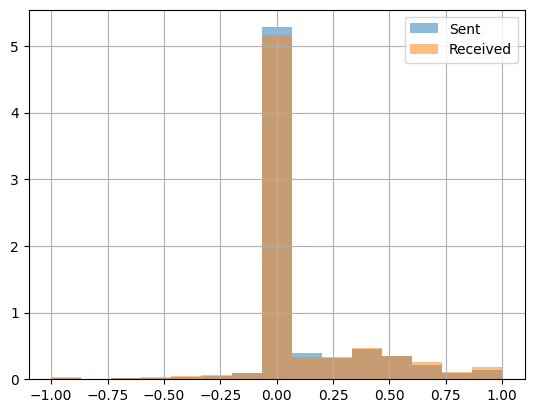

In [10]:
send_df = df[df['from_id']==MY_UID]
recv_df = df[df['to_id']==MY_UID]
send_df.tone_normalized.hist(bins=15, alpha=0.5, density=True, label='Sent')
recv_df.tone_normalized.hist(bins=15, alpha=0.5, density=True, label='Received')
plt.legend()

## 1.2 What are the distribution of message tones accross groups?

In [11]:
df[df['dialog_type'] == 'Group'].groupby('dialog_id')['tone_normalized'].mean().hist(bins=15)

<Axes: >

## 1.3 What are the average tone of messages for different groups?

In [12]:
plt.figure(figsize=(15, 5))
df[df['dialog_type'] == 'Group'].groupby('dialog_id')['tone_normalized'].mean().sort_values().plot(kind='bar')

<Axes: xlabel='dialog_id'>

# 2. Topic Modeling

Here we aggregated the messages by dialog and day. Then performed HDBSCAN clusterization to identify the clusters (topics)

In [13]:
df_ = (
    df.groupby(['dialog_id', 'date'])
    .agg({
        'message_proc': lambda messages: ' '.join(messages),
        'tone': 'sum',
        'tone_normalized': 'mean',
        'word2vec': lambda vectors: np.mean(np.stack(vectors), axis=0),
        'from_id': 'count'
    })
    .reset_index()
    .rename(columns={'from_id': 'message_count'})
)

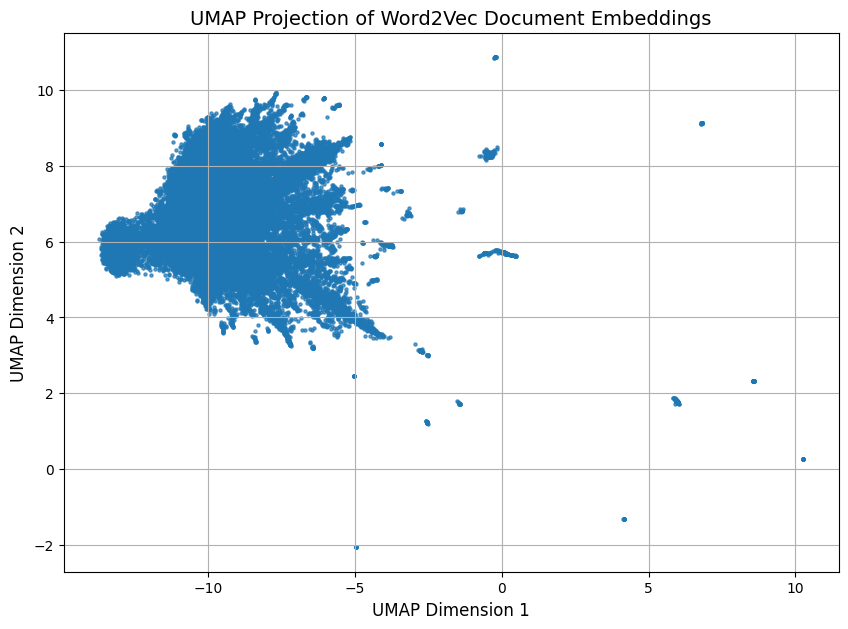

In [14]:
document_vectors = np.vstack(df_['word2vec'].values)
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', n_components=2)
reduced_vectors_umap = umap_reducer.fit_transform(document_vectors)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_vectors_umap[:, 0], reduced_vectors_umap[:, 1], s=5, alpha=0.7)
plt.title("UMAP Projection of Word2Vec Document Embeddings", fontsize=14)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.grid(True)
plt.show()

In [15]:
document_vectors = np.vstack(df_['word2vec'].values)

hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10, 
    min_samples=3,       
    cluster_selection_epsilon=0.005, 
    core_dist_n_jobs=-1
)
clusters = hdbscan_clusterer.fit_predict(document_vectors)

df_['cluster'] = clusters

cluster_common_words = {}
for cluster_id in sorted(df_['cluster'].unique()):
    if cluster_id == -1:
        continue
    cluster_messages = ' '.join(df_.loc[df_['cluster'] == cluster_id, 'message_proc'].tolist())
    word_counts = Counter(cluster_messages.split())
    cluster_common_words[cluster_id] = word_counts.most_common(100)

for cluster_id, common_words in cluster_common_words.items():
    print(f"Cluster {cluster_id}:")
    for word, count in common_words:
        print(f"  {word}: {count}")
    print()

Cluster 0:
  –ø–µ—Ä–µ–∫–ª–∏—á–∫–∞: 12

Cluster 1:
  üëã: 15

Cluster 2:
  –∂–∫: 44
  avalon: 44
  prime: 44
  —Ö—ñ–¥: 43
  –±—É–¥—ñ–≤–Ω–∏—Ü—Ç–≤–∞: 43
  –±—É–¥–∏–Ω–æ–∫: 43
  –Ω–æ–≤–∏–Ω–∏: 17
  üî∏–æ–Ω–æ–≤–∏–ª–∏: 17
  –¥–∏–≤–∏—Ç–∏—Å—å: 17
  –¥–µ—Ç–∞–ª—ñ: 17
  —Ñ–æ—Ç–æüî∏: 16
  –∑–±—É–¥–æ–≤–∞–Ω–æ: 15
  –ª—é—Ç–∏–π: 3
  –±–µ—Ä–µ–∑–µ–Ω—å: 3
  –∫–≤—ñ—Ç–µ–Ω—å: 3
  —Ç—Ä–∞–≤–µ–Ω—å: 3
  —á–µ—Ä–≤–µ–Ω—å: 3
  –ª–∏–ø–µ–Ω—å: 3
  —Å–µ—Ä–ø–µ–Ω—å: 3
  –∂–æ–≤—Ç–µ–Ω—å: 2
  –ª–∏—Å—Ç–æ–ø–∞–¥: 2
  –≥—Ä—É–¥–µ–Ω—å: 2
  –±—É–¥—É—î—Ç—å—Å—è: 1
  —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏üî∏: 1
  –ø–æ–≤–µ—Ä—Ö–æ–≤—ñ—Å—Ç—å: 1

Cluster 3:
  –Ω–æ–≤–∏–º: 22
  —Ä–æ–∫–æ–º: 22
  ü•≥ü•≥ü•≥: 9
  —Å–æ–Ω—Ü–µüòö‚ù§Ô∏è: 1
  ‚ú®‚ú®‚ú®: 1
  üéÑüéÑüéÑ: 1

Cluster 4:
  üëã: 16
  –º–∏—Ç–Ω–∏–∫: 3
  —Å—Ç–∞–≤—à–∏: 3
  –Ω–∞–π–±—ñ–ª—å—à–∏–π: 3
  –Ω–∞–±—ñ—Ä: 2
  –∞–ª–≥–æ—Ä–∏—Ç–º: 2
  –º–∞—î–º–æ: 2
  —Ä–æ–∑–≥–ª—è–Ω—É—Ç–∏: 2
  —è–∫–∏—Å—å: 2
  —Ñ–∞—Ä–∏—Å–µ–π: 2
  –±–æ–∂–µ: 2
  —Ü–∞—Ä—Å—Ç–≤—ñ: 2
  –ø–æ–∫–ª–∏–∫–∞–≤: 2
  –±—É–≤—à–∏: 2
  —Å–º–µ—Ä—Ç

- Cluster 0 and 1: Looks like outliers
- Cluster 2: Is the topic of real estate announcements
- Cluster 3: Is the greetings with New Year
- Cluster 4: Is a mix of many topics
- Cluster 5: Is the topic of IT job offerings
- Cluster 6: Is the topic of Ukrainian startups
- Cluster 7: Is another topic of IT job offerings

# 3. Messages activity

## 3.1. What is my activity during the day?

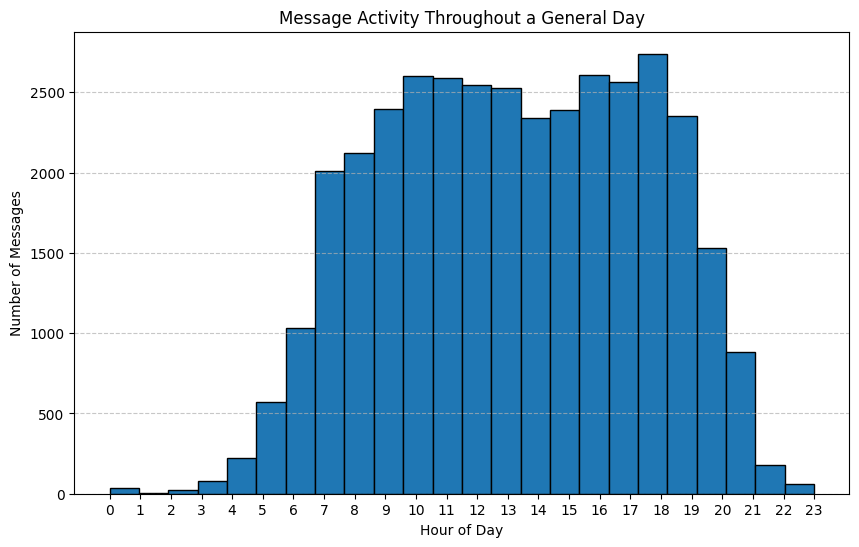

In [16]:
sent_df = df[df['from_id'] == MY_UID].copy()
sent_df['day_of_week'] = sent_df['date_time'].dt.day_name()
sent_df['hour'] = sent_df['date_time'].dt.hour

plt.figure(figsize=(10, 6))
plt.hist(sent_df['hour'], bins=24, range=(0, 23), edgecolor='black')
plt.title('Message Activity Throughout a General Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3.2 What is my activity for each day of week?

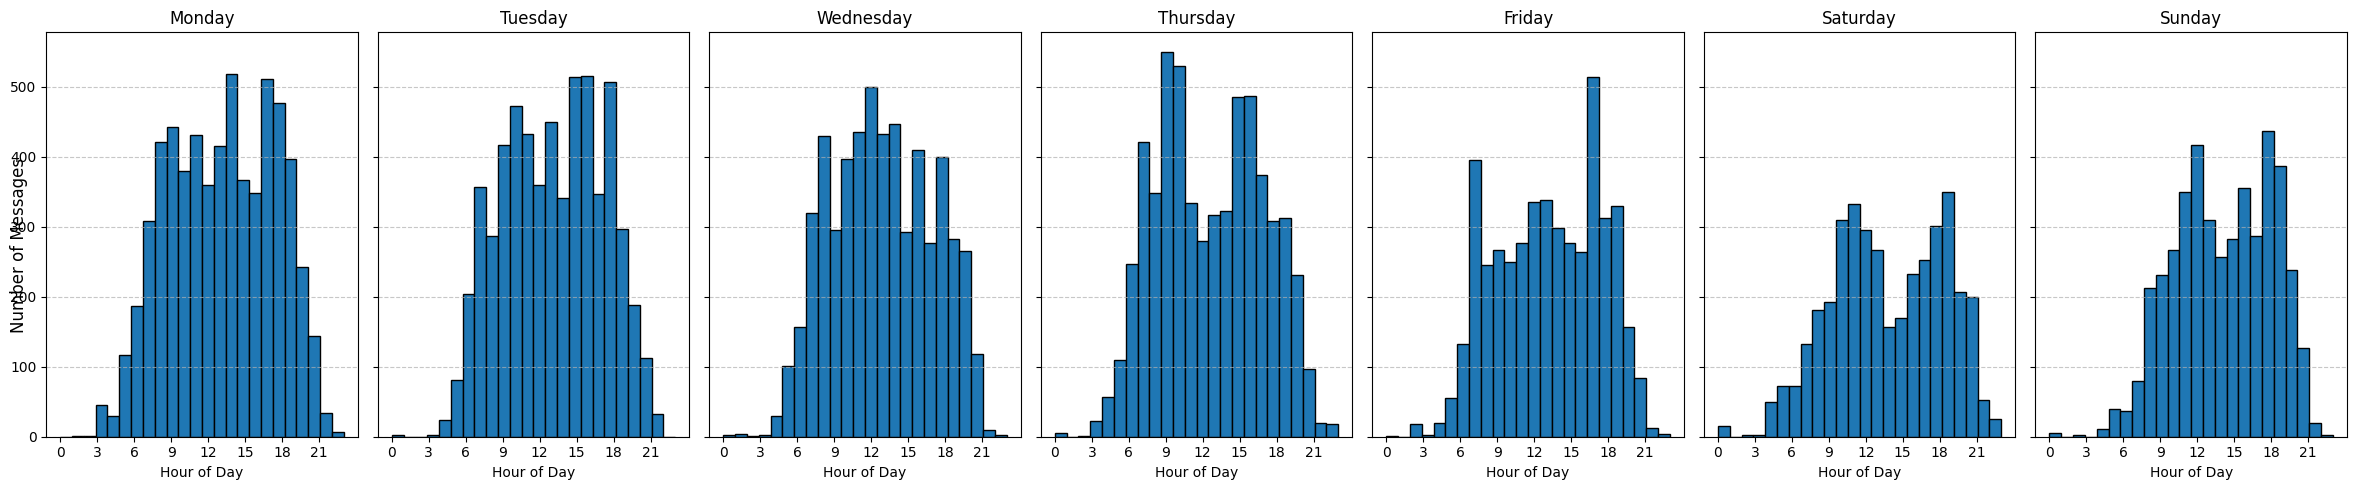

In [17]:
sent_df = df[df['from_id'] == MY_UID].copy()
sent_df['day_of_week'] = sent_df['date_time'].dt.day_name()
sent_df['hour'] = sent_df['date_time'].dt.hour

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axes = plt.subplots(1, 7, figsize=(24, 5), sharey=True)

for ax, day in zip(axes, day_order):
    day_data = sent_df[sent_df['day_of_week'] == day]['hour']
    ax.hist(day_data, bins=24, range=(0, 23), edgecolor='black')
    ax.set_title(day)
    ax.set_xlabel('Hour of Day')
    ax.set_xticks(range(0, 24, 3))
    ax.grid(axis='y', linestyle='--', alpha=0.7)

fig.supylabel('Number of Messages', fontsize=12)
plt.tight_layout()
plt.show()

# 4. Recognize the interlocutors‚Äô genders

Here we used `gender_guesser` library to create rough ground truth. Then we have thrown out data points of unidentified genders and balanced classes by undersampling (oversampling didn't work well). Then we trained the Random Forest Classifier to predict gender based on message text.

In [18]:
d = gender.Detector()
df_ = df.copy()
df_ = df_[df_['from_id'] != MY_UID]
df_ = df[df['dialog_type'] == 'Private dialog']
df_ = df_[df_['name'].isna() == False]

def guess_gender(full_name):
    name_parts = full_name.split()
    genders = [d.get_gender(part) for part in name_parts]
    normalized_genders = [g.replace('mostly_female', 'female').replace('mostly_male', 'male') for g in genders if g != 'unknown']
    if not normalized_genders:
        return 'unknown'
    most_common_gender = Counter(normalized_genders).most_common(1)
    return most_common_gender[0][0] if most_common_gender else 'unknown'  # Default to 'unknown' if no gender

df_['guessed_gender'] = df_['name'].apply(guess_gender)
df_ = df_[df_['guessed_gender'] != 'unknown']
df_ = df_[df_['message'].str.len() > 0]

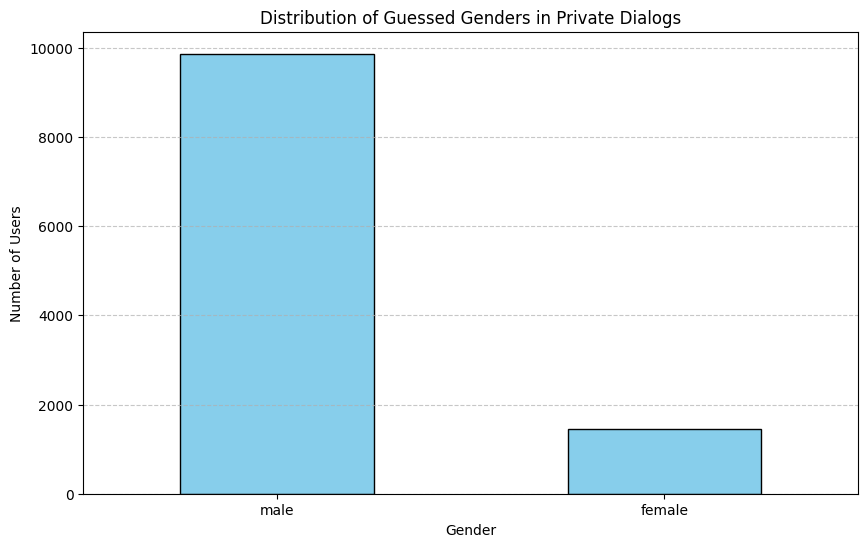

In [19]:
gender_counts = df_['guessed_gender'].value_counts()
gender_counts.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6))
plt.title('Distribution of Guessed Genders in Private Dialogs')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
corpus = df_['message'].str.split().tolist()
w2v_model = Word2Vec(sentences=corpus, vector_size=128, window=5, min_count=1, workers=-1, sg=1)
df_['word2vec_vector'] = df_['message'].str.split().apply(lambda x: compute_document_embedding(x, w2v_model))

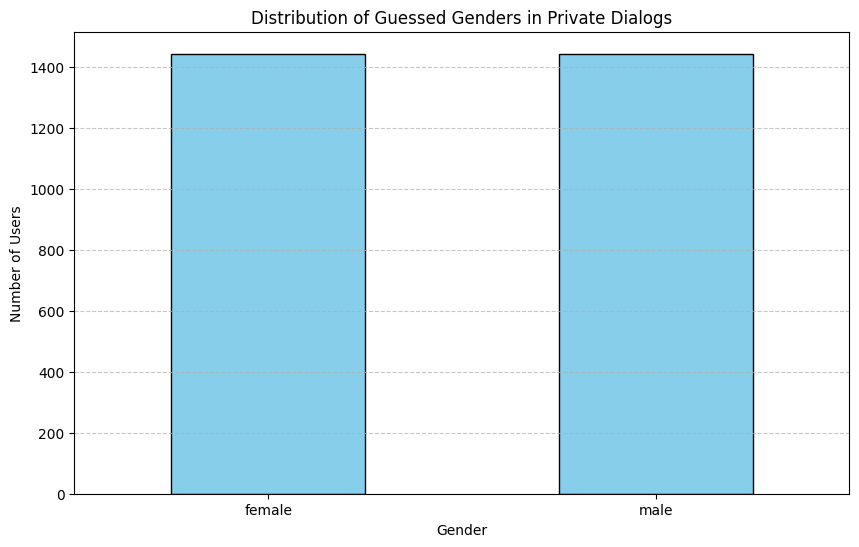

In [21]:
X = np.vstack(df_['word2vec_vector'].values)
y = df_['guessed_gender']

sampler = RandomUnderSampler(sampling_strategy=1, random_state=42)
X, y = sampler.fit_resample(X, y)

gender_counts = y.value_counts()
gender_counts.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6))
plt.title('Distribution of Guessed Genders in Private Dialogs')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5622837370242214

Classification Report:
               precision    recall  f1-score   support

      female       0.57      0.49      0.53       289
        male       0.55      0.63      0.59       289

    accuracy                           0.56       578
   macro avg       0.56      0.56      0.56       578
weighted avg       0.56      0.56      0.56       578



In [23]:
new_message = "C–æ–Ω—Ü–µ!".split()
new_message_embedding = compute_document_embedding(new_message, w2v_model).reshape(1, -1)
predicted_gender = model.predict(new_message_embedding)
print("Predicted Gender:", predicted_gender[0])

Predicted Gender: female


In [24]:
new_message = "–ü—Ä–∏–≤—ñ—Ç!".split()
new_message_embedding = compute_document_embedding(new_message, w2v_model).reshape(1, -1)
predicted_gender = model.predict(new_message_embedding)
print("Predicted Gender:", predicted_gender[0])

Predicted Gender: male


# 5. What is the distribution of languages?

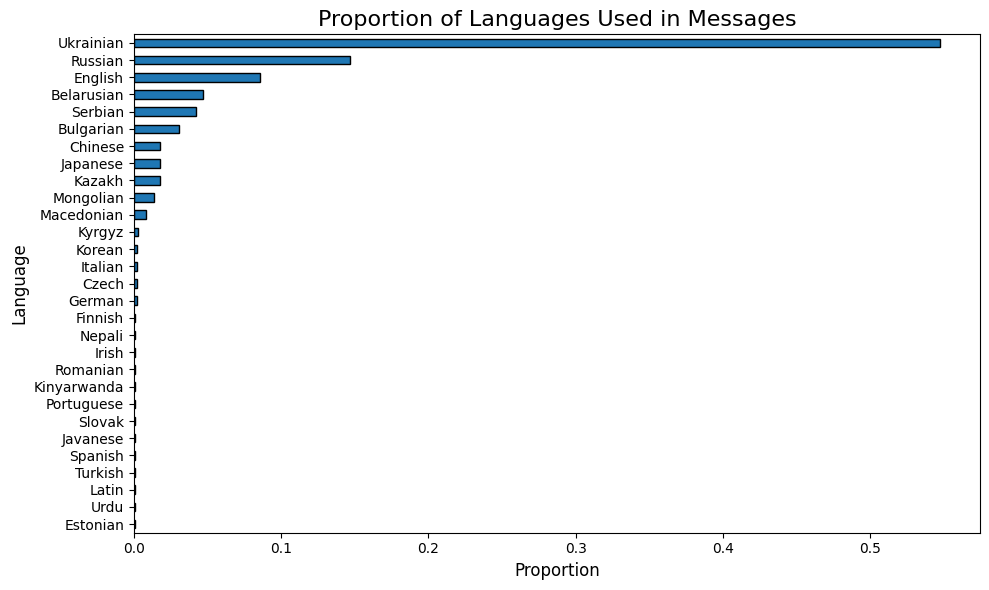

In [25]:
identifier = LanguageIdentifier.from_modelstring(lang_model, norm_probs=True)
df_ = df[['message']].dropna().sample(1000).copy()

def detect_language(text):
    try:
        lang, prob = identifier.classify(text)
        return lang
    except Exception:
        return "unknown"

df_['language'] = df_['message'].apply(detect_language)

threshold = 0.001
language_counts = df_['language'].value_counts(normalize=True)
frequent_languages = language_counts[language_counts >= threshold]
other_languages = language_counts[language_counts < threshold].sum()

if other_languages > 0:
    frequent_languages['Others'] = other_languages

def get_language_name(code):
    try:
        return langcodes.get(code).language_name()
    except LookupError:
        return code 

frequent_languages.index = [get_language_name(lang) for lang in frequent_languages.index]

plt.figure(figsize=(10, 6))
frequent_languages.sort_values().plot(
    kind='barh',
    colormap='tab10',
    edgecolor='black'
)
plt.title('Proportion of Languages Used in Messages', fontsize=16)
plt.xlabel('Proportion', fontsize=12)
plt.ylabel('Language', fontsize=12)
plt.tight_layout()
plt.show()